# 01 — Exploratory Data Analysis

Load the processed monthly panel and explore the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
pd.options.display.max_columns = 20

In [2]:
panel = pd.read_parquet("../data/processed/panel.parquet")
print(f"Shape: {panel.shape}")
print(f"Range: {panel.index.min().date()} to {panel.index.max().date()}")
panel.head(10)

Shape: (182, 7)
Range: 2011-01-01 to 2026-02-01


,inadimplencia_pf_total,inadimplencia_carteira_total,selic_acumulada_mes,ibc_br_dessaz,cambio_ptax_venda,taxa_desocupacao,rendimento_medio_real
date,,,,,,,
2011-01-01,NaN,NaN,0.86,98.55374,1.674914,NaN,NaN
2011-02-01,NaN,NaN,0.84,98.93183,1.667990,NaN,NaN
2011-03-01,4.62,3.17,0.92,98.95436,1.659100,NaN,NaN
2011-04-01,4.67,3.24,0.84,98.97257,1.586447,NaN,NaN
2011-05-01,4.82,3.37,0.99,99.14907,1.613491,NaN,NaN
2011-06-01,4.79,3.32,0.96,99.58292,1.587043,NaN,NaN
2011-07-01,4.90,3.42,0.97,99.67674,1.563938,NaN,NaN
2011-08-01,4.97,3.45,1.07,99.57173,1.597009,NaN,NaN
2011-09-01,5.03,3.46,0.94,99.47299,1.749776,NaN,NaN


## Missing Values

In [3]:
panel.isnull().sum()

inadimplencia_pf_total           4
inadimplencia_carteira_total     4
selic_acumulada_mes              0
ibc_br_dessaz                    3
cambio_ptax_venda                0
taxa_desocupacao                16
rendimento_medio_real           16
dtype: int64

## Time Series Plots

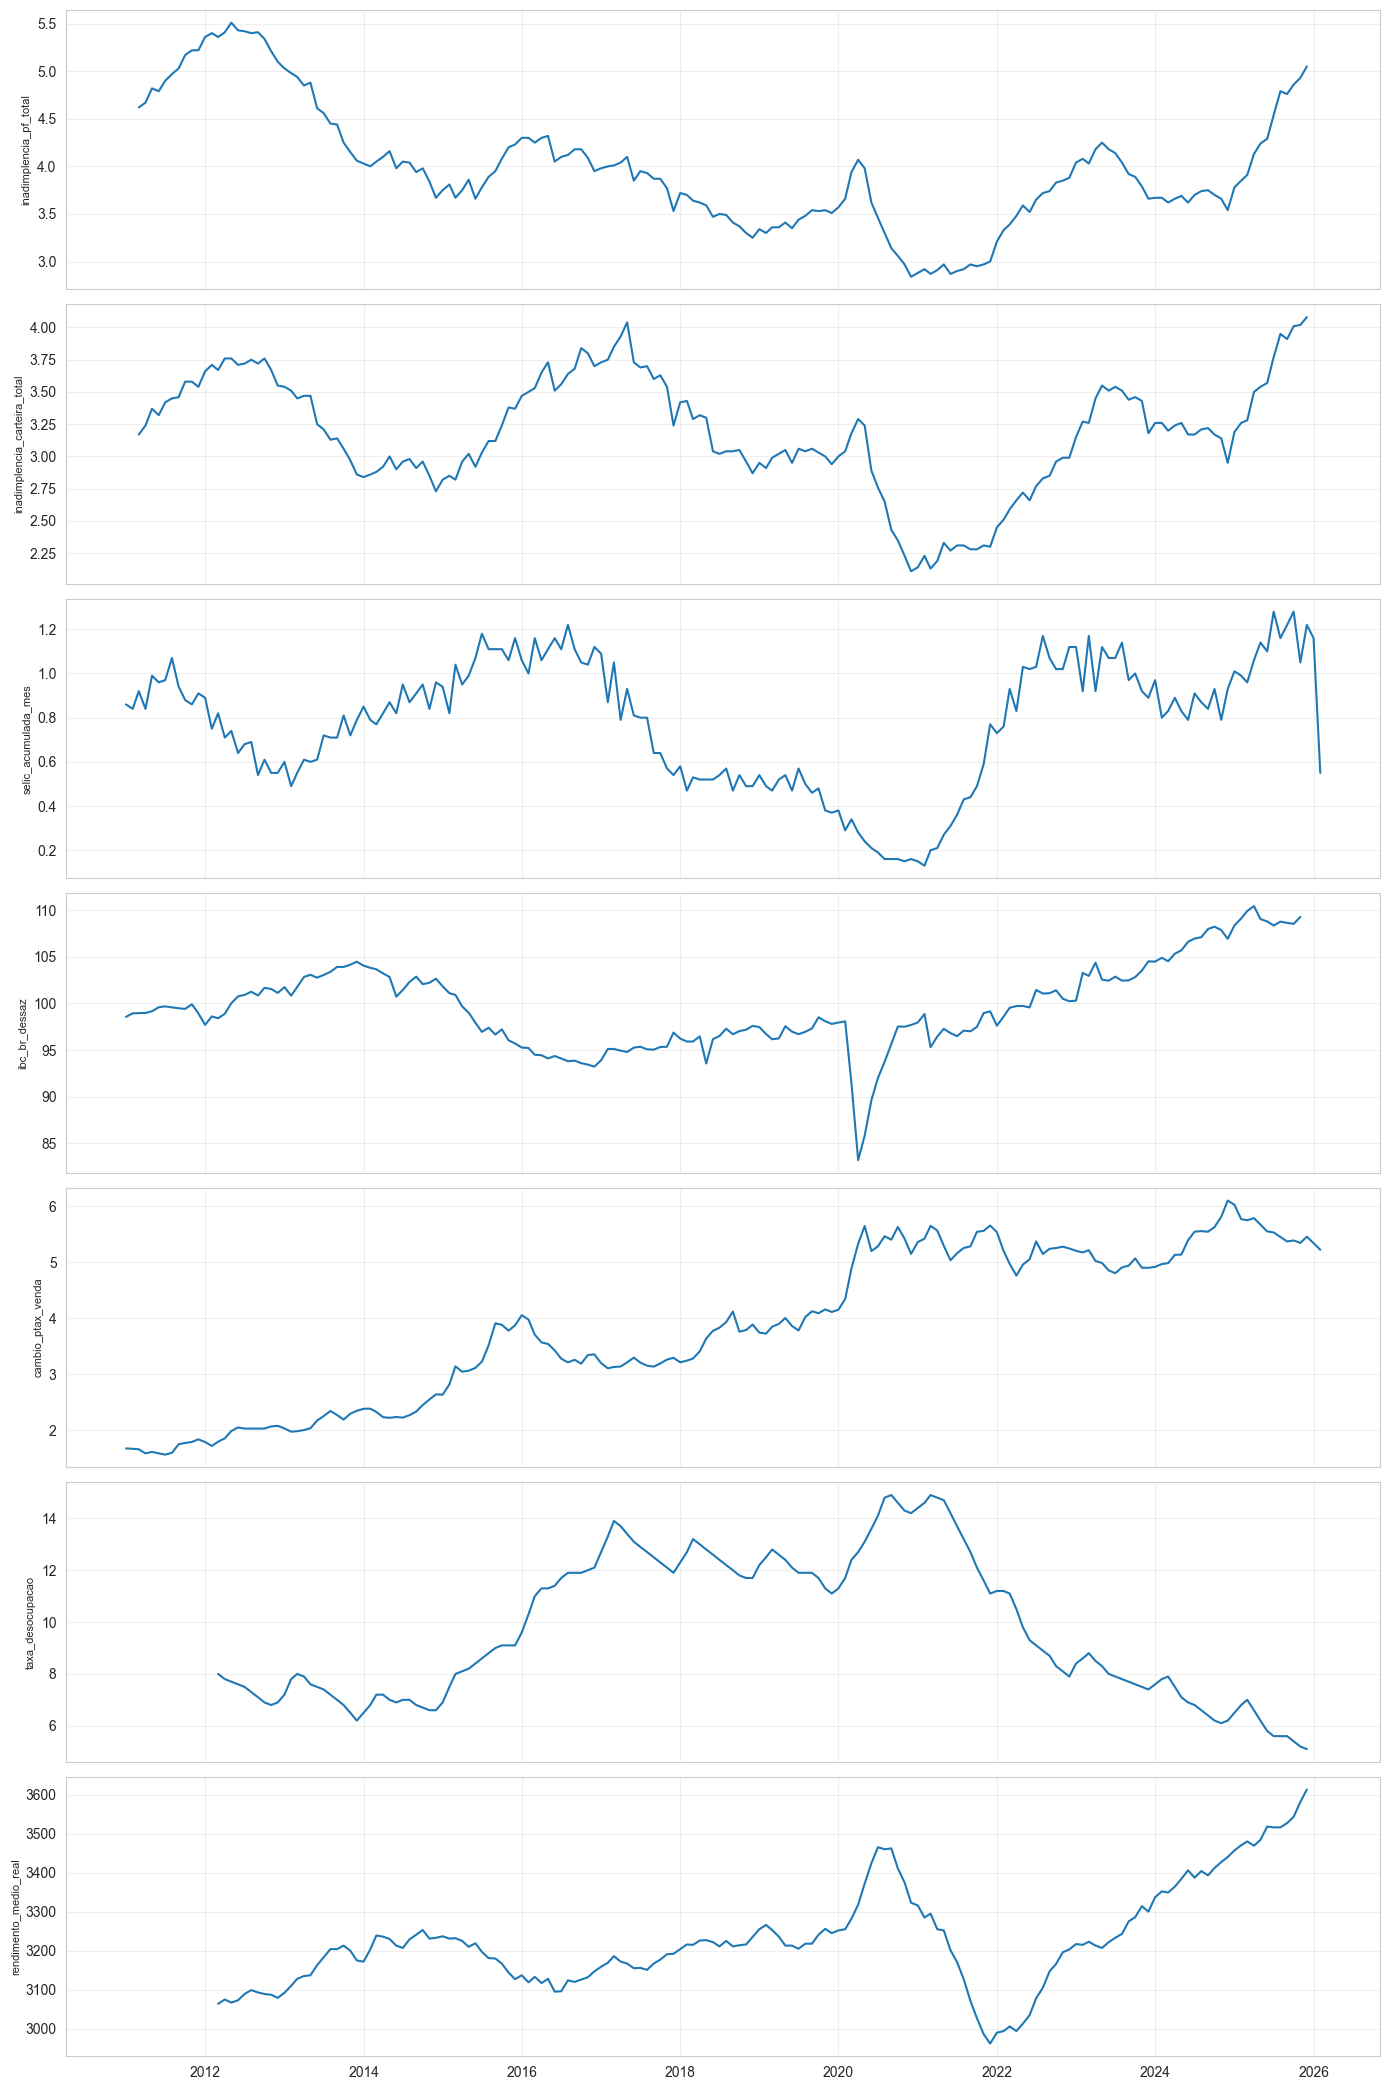

In [4]:
fig, axes = plt.subplots(len(panel.columns), 1, figsize=(14, 3 * len(panel.columns)), sharex=True)
for ax, col in zip(axes, panel.columns):
    ax.plot(panel.index, panel[col])
    ax.set_ylabel(col, fontsize=8)
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Correlation Matrix

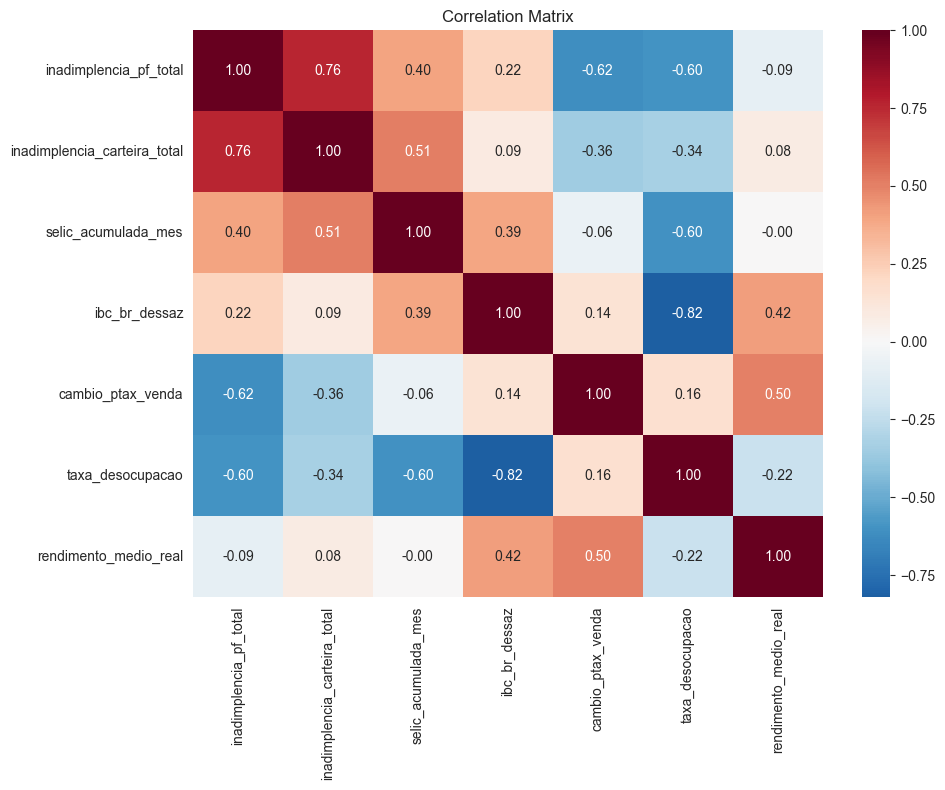

In [4]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(panel.corr(), annot=True, fmt=".2f", cmap="RdBu_r", center=0, ax=ax)
ax.set_title("Correlation Matrix")
plt.tight_layout()
plt.show()

## Descriptive Statistics

In [5]:
panel.describe()

,inadimplencia_pf_total,inadimplencia_carteira_total,selic_acumulada_mes,ibc_br_dessaz,cambio_ptax_venda,taxa_desocupacao,rendimento_medio_real
count,178.000000,178.000000,182.000000,179.000000,182.000000,166.000000,166.000000
mean,3.982978,3.186517,0.777473,99.636101,3.845385,9.736747,3227.734940
std,0.645279,0.446193,0.288596,4.563918,1.363887,2.783943,128.514787
min,2.840000,2.110000,0.130000,83.193540,1.563938,5.100000,2962.000000
25%,3.575000,2.950000,0.542500,96.672035,2.473287,7.200000,3147.000000
50%,3.900000,3.205000,0.830000,99.000420,3.837624,8.950000,3213.000000
75%,4.247500,3.537500,1.017500,102.698030,5.199661,12.175000,3263.500000
max,5.510000,4.080000,1.280000,110.422720,6.097029,14.900000,3613.000000


---

# Enhanced EDA — Diagnosing Macro-Variable Predictive Power

The sections below investigate **why** univariate ARIMA outperforms macro-augmented models in walk-forward evaluation. We test hypotheses around target persistence, predictor instability, Granger causality failure, multicollinearity, and suboptimal lag structures.

In [6]:
import numpy as np
import warnings
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, coint
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from matplotlib.patches import Rectangle

import sys
sys.path.insert(0, "..")
from src.features import build_features, FEATURE_COLS, TARGET_COL

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*kpss.*")

## Section 1: Target Deep-Dive

Time series with crisis annotations, ACF/PACF plots, and volatility analysis.

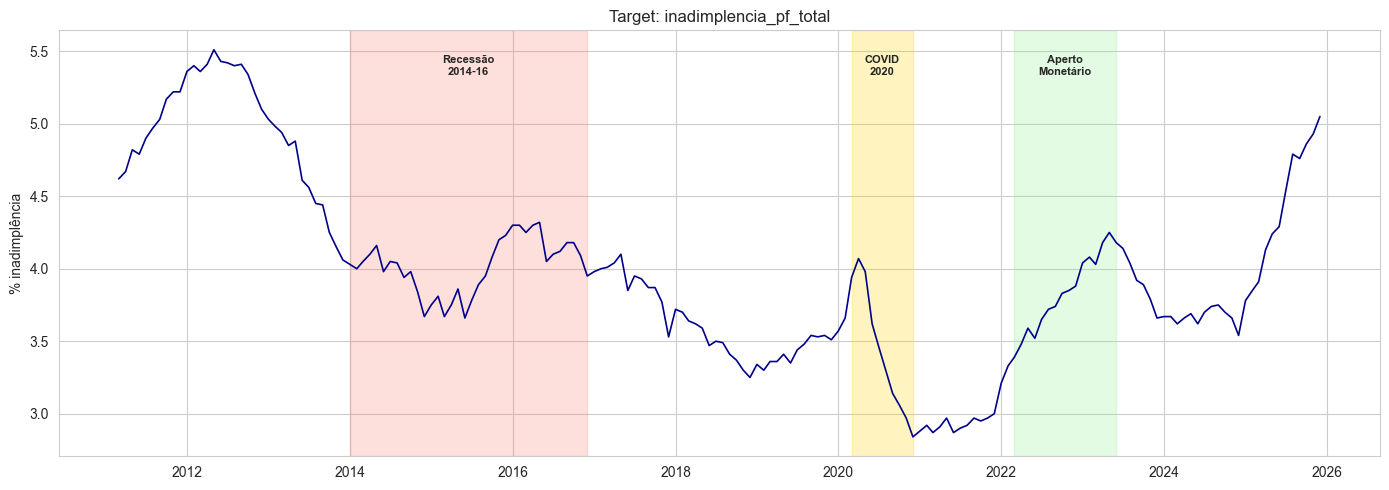

In [7]:
target = panel[TARGET_COL].dropna()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(target.index, target.values, color="darkblue", linewidth=1.2)

# Annotate crisis periods
crisis_periods = [
    ("2014-01", "2016-12", "Recessão\n2014-16", "salmon"),
    ("2020-03", "2020-12", "COVID\n2020", "gold"),
    ("2022-03", "2023-06", "Aperto\nMonetário", "lightgreen"),
]
for start, end, label, color in crisis_periods:
    s, e = pd.Timestamp(start), pd.Timestamp(end)
    ax.axvspan(s, e, alpha=0.25, color=color, label=label)
    ax.text(s + (e - s) / 2, ax.get_ylim()[1] * 0.97, label,
            ha="center", va="top", fontsize=8, fontweight="bold")

ax.set_title(f"Target: {TARGET_COL}")
ax.set_ylabel("% inadimplência")
plt.tight_layout()
plt.show()

Three distinct cycles are visible:

  1. 2011–2013 (peak ~5.5%): Default rates were high, reflecting the tail end of
  the post-2008 credit expansion. The Dilma government's interventionist policies
  and loose credit were already showing stress.
  2. 2014–2016 Recession (shaded red): Counterintuitively, defaults fell during
  this period (from ~4.3% to ~3.7%). This likely reflects credit contraction —
  banks tightened lending, so the denominator shifted toward safer borrowers. Fewer
   new risky loans = lower default rate, even amid recession.
  3. 2017–2019 (gradual decline to ~3.5%): Continued deleveraging and the
  Temer/early Bolsonaro reforms period. The series reaches a long downtrend trough.
  4. COVID 2020 (shaded yellow): A sharp V-shape — brief spike to ~4% then a plunge
   to the historical low (~2.9%). Government stimulus (auxílio emergencial) and
  debt moratoriums artificially suppressed defaults.
  5. 2022–2023 Monetary Tightening (shaded green): As Selic rose aggressively,
  defaults climbed back up, reflecting the lagged pass-through of higher rates to
  borrowers.
  6. 2025–2026 (latest): A sharp acceleration back to ~5%, approaching 2011 levels
  — this is the current concern.

  Implications for modeling:

  - The series exhibits strong regime dependence — the relationship between macro
  variables and defaults likely changes sign across these periods (e.g., recession
  lowering defaults via credit rationing contradicts the naive expectation).
  - The non-stationary, multi-cycle nature explains why ARIMA's local persistence
  captures the trend well, while macro-augmented models struggle with relationships
   that flip across regimes.
  - The COVID dip is an outlier event driven by policy intervention, not organic
  macro dynamics — any model trained through this period will face structural
  instability.

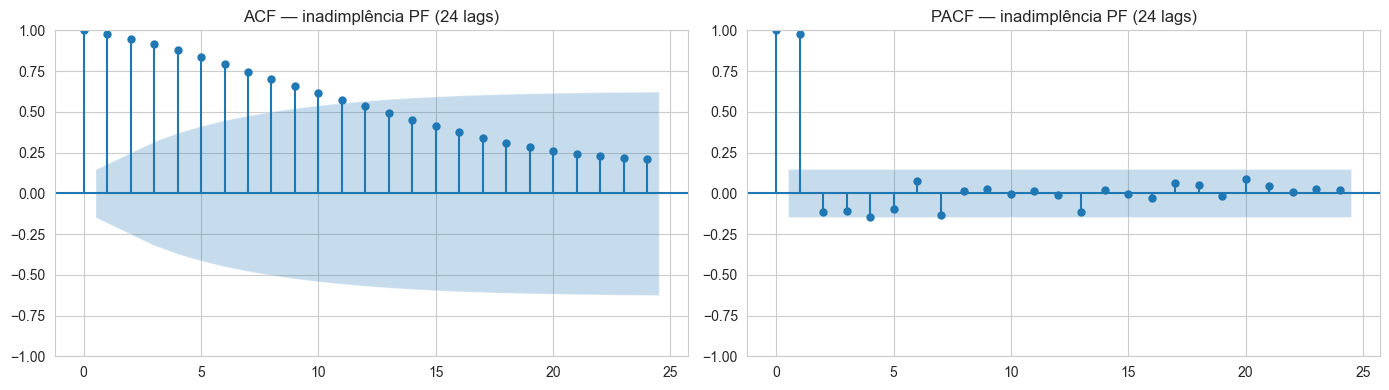

Interpretation: high ACF persistence means the target's own past is very
informative — a strong prior that ARIMA can exploit without exogenous help.


In [8]:
# ACF / PACF — shows target persistence (explains ARIMA advantage)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(target, lags=24, ax=axes[0], title="ACF — inadimplência PF (24 lags)")
plot_pacf(target, lags=24, ax=axes[1], title="PACF — inadimplência PF (24 lags)")
plt.tight_layout()
plt.show()

print("Interpretation: high ACF persistence means the target's own past is very")
print("informative — a strong prior that ARIMA can exploit without exogenous help.")

ACF (left) — Slow, linear decay:

  - Autocorrelations remain significant (above the confidence band) for all 24
  lags, decaying very slowly from ~0.97 at lag 1 to ~0.25 at lag 24.
  - This is the textbook signature of a non-stationary or near-unit-root process —
  each month's value is almost entirely determined by the previous month's value.
  - Even 2 years back, the series retains ~25% correlation — the "memory" is
  extremely long.

  PACF (right) — Sharp cutoff after lag 1:

  - A single dominant spike at lag 1 (~0.97), then everything drops inside the
  confidence band.
  - This is the classic AR(1) fingerprint — after controlling for the immediate
  previous value, no additional lag carries significant independent information.

  What this means for the project:

  1. ARIMA's advantage explained: A simple AR(1) captures ~97% of the
  month-to-month variation. This leaves almost no residual variance for macro
  variables to explain — they're competing for the remaining ~3%.
  2. The macro variable problem: For an exogenous predictor to beat ARIMA, it would
   need to predict that small residual better than the AR structure already does.
  Given the noise in macro series (forward-filled PNAD, regime instability), they
  likely add more noise than signal.
  3. Modeling implication: The series behaves as an I(1) process (ACF decays
  linearly, PACF cuts at lag 1). This confirms the stationarity tests — models
  should work on first differences, where macro variables might have a better
  chance of contributing since the AR persistence is removed.
  4. Suggested ARIMA order: The PACF suggests p=1 is sufficient for the AR
  component. The slow ACF decay suggests d=1 differencing. After differencing,
  re-examine ACF/PACF to determine the MA component.

  In short: the target is so persistent that knowing yesterday's value is almost
  all you need — leaving very little room for macro predictors to add value.

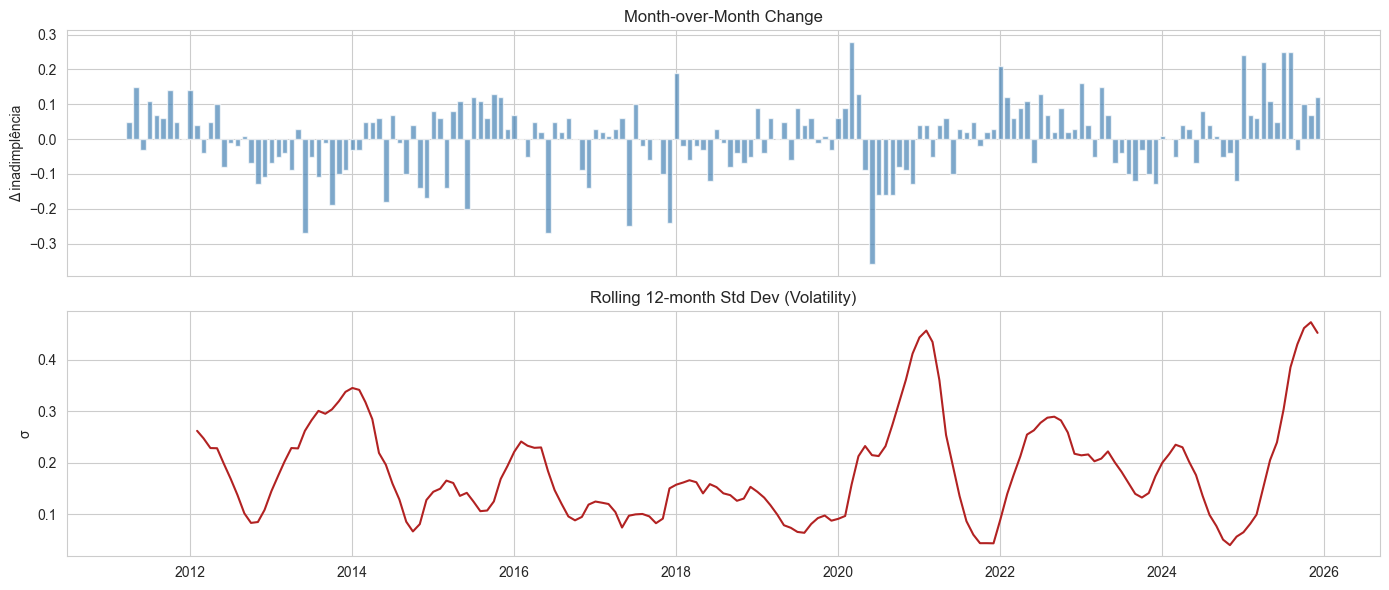

In [9]:
# Month-over-month changes + rolling volatility
mom = target.diff()
rolling_std = target.rolling(12).std()

fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
axes[0].bar(mom.index, mom.values, color="steelblue", width=25, alpha=0.7)
axes[0].set_title("Month-over-Month Change")
axes[0].set_ylabel("Δ inadimplência")

axes[1].plot(rolling_std.index, rolling_std.values, color="firebrick", linewidth=1.5)
axes[1].set_title("Rolling 12-month Std Dev (Volatility)")
axes[1].set_ylabel("σ")
plt.tight_layout()
plt.show()

## Section 2: Stationarity Tests

ADF and KPSS tests on levels and first differences for all variables.

In [35]:
all_vars = [TARGET_COL] + FEATURE_COLS
rows = []

for col in all_vars:
    s = panel[col].dropna()
    if len(s) < 20:
        continue
    # Levels
    adf_stat, adf_p, *_ = adfuller(s, autolag="AIC")
    kpss_stat, kpss_p, *_ = kpss(s, regression="c", nlags="auto")

    # First difference
    sd = s.diff().dropna()
    adf_d_stat, adf_d_p, *_ = adfuller(sd, autolag="AIC")
    kpss_d_stat, kpss_d_p, *_ = kpss(sd, regression="c", nlags="auto")

    order = 0 if (adf_p < 0.05 and kpss_p > 0.05) else (1 if (adf_d_p < 0.05) else 2)

    rows.append({
        "variable": col,
        "ADF_level_p": round(adf_p, 4),
        "KPSS_level_p": round(kpss_p, 4),
        "ADF_diff_p": round(adf_d_p, 4),
        "KPSS_diff_p": round(kpss_d_p, 4),
        "I(d)": order,
    })

stationarity_df = pd.DataFrame(rows)
print("Stationarity summary (ADF H0: unit root; KPSS H0: stationary)")
stationarity_df

Stationarity summary (ADF H0: unit root; KPSS H0: stationary)


/var/folders/rt/bx_s6gbj0n97452_nhktcqy00000gn/T/ipykernel_22845/4029872842.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(s, regression="c", nlags="auto")
/var/folders/rt/bx_s6gbj0n97452_nhktcqy00000gn/T/ipykernel_22845/4029872842.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_d_stat, kpss_d_p, *_ = kpss(sd, regression="c", nlags="auto")
/var/folders/rt/bx_s6gbj0n97452_nhktcqy00000gn/T/ipykernel_22845/4029872842.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(s, regression="c", nlags="auto")
/var/folders/rt/bx_s6gbj0n97452_nhktcqy00000gn/T/ipyk

,variable,ADF_level_p,KPSS_level_p,ADF_diff_p,KPSS_diff_p,I(d)
0,inadimplencia_pf_total,0.2041,0.0100,0.0544,0.100,2
1,inadimplencia_carteira_total,0.2531,0.1000,0.0582,0.100,2
2,selic_acumulada_mes,0.1237,0.1000,0.0464,0.100,1
3,ibc_br_dessaz,0.6649,0.0449,0.0000,0.100,1
4,cambio_ptax_venda,0.6021,0.0100,0.0000,0.100,1
5,taxa_desocupacao,0.6498,0.0647,0.0966,0.049,2
6,rendimento_medio_real,0.8180,0.0147,0.0000,0.100,1


## Section 3: Structural Breaks & Regime Changes

Rolling statistics and per-regime correlation analysis.

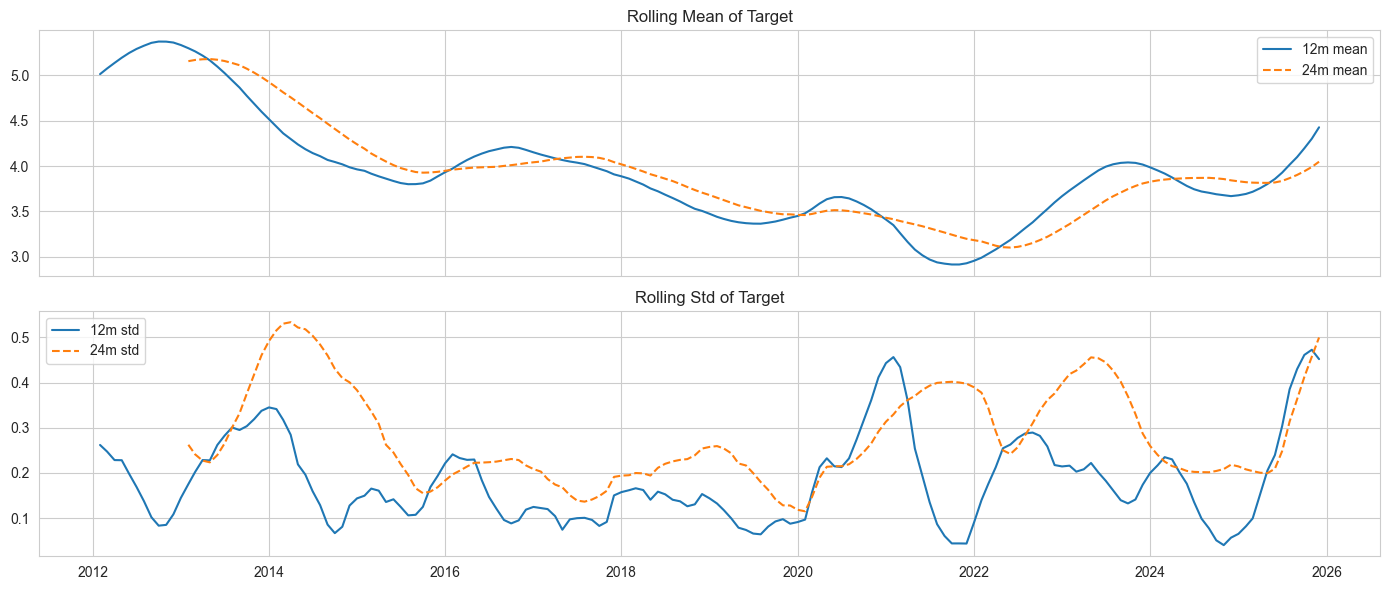

In [11]:
# Rolling mean and std of target
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
for w, ls in [(12, "-"), (24, "--")]:
    axes[0].plot(target.rolling(w).mean(), label=f"{w}m mean", linestyle=ls)
    axes[1].plot(target.rolling(w).std(), label=f"{w}m std", linestyle=ls)
axes[0].set_title("Rolling Mean of Target")
axes[0].legend()
axes[1].set_title("Rolling Std of Target")
axes[1].legend()
plt.tight_layout()
plt.show()

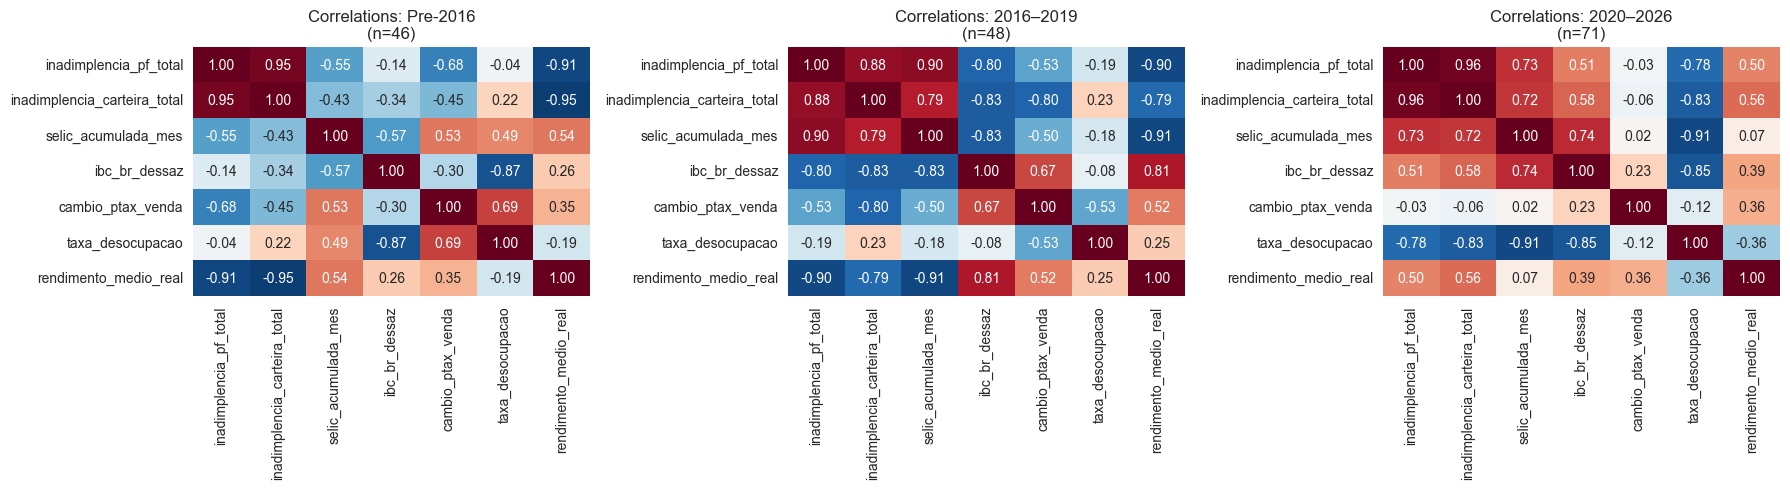

Key question: are predictor-target correlations stable across regimes?


In [12]:
# Per-regime correlation heatmaps
regimes = {
    "Pre-2016": panel.loc[:"2015-12"],
    "2016–2019": panel.loc["2016-01":"2019-12"],
    "2020–2026": panel.loc["2020-01":],
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, sub) in zip(axes, regimes.items()):
    corr = sub.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
                ax=ax, cbar=False, vmin=-1, vmax=1)
    ax.set_title(f"Correlations: {name}\n(n={len(sub.dropna())})")
plt.tight_layout()
plt.show()

print("Key question: are predictor-target correlations stable across regimes?")

## Section 4: Seasonal Decomposition

STL decomposition, seasonal subseries, and periodogram.

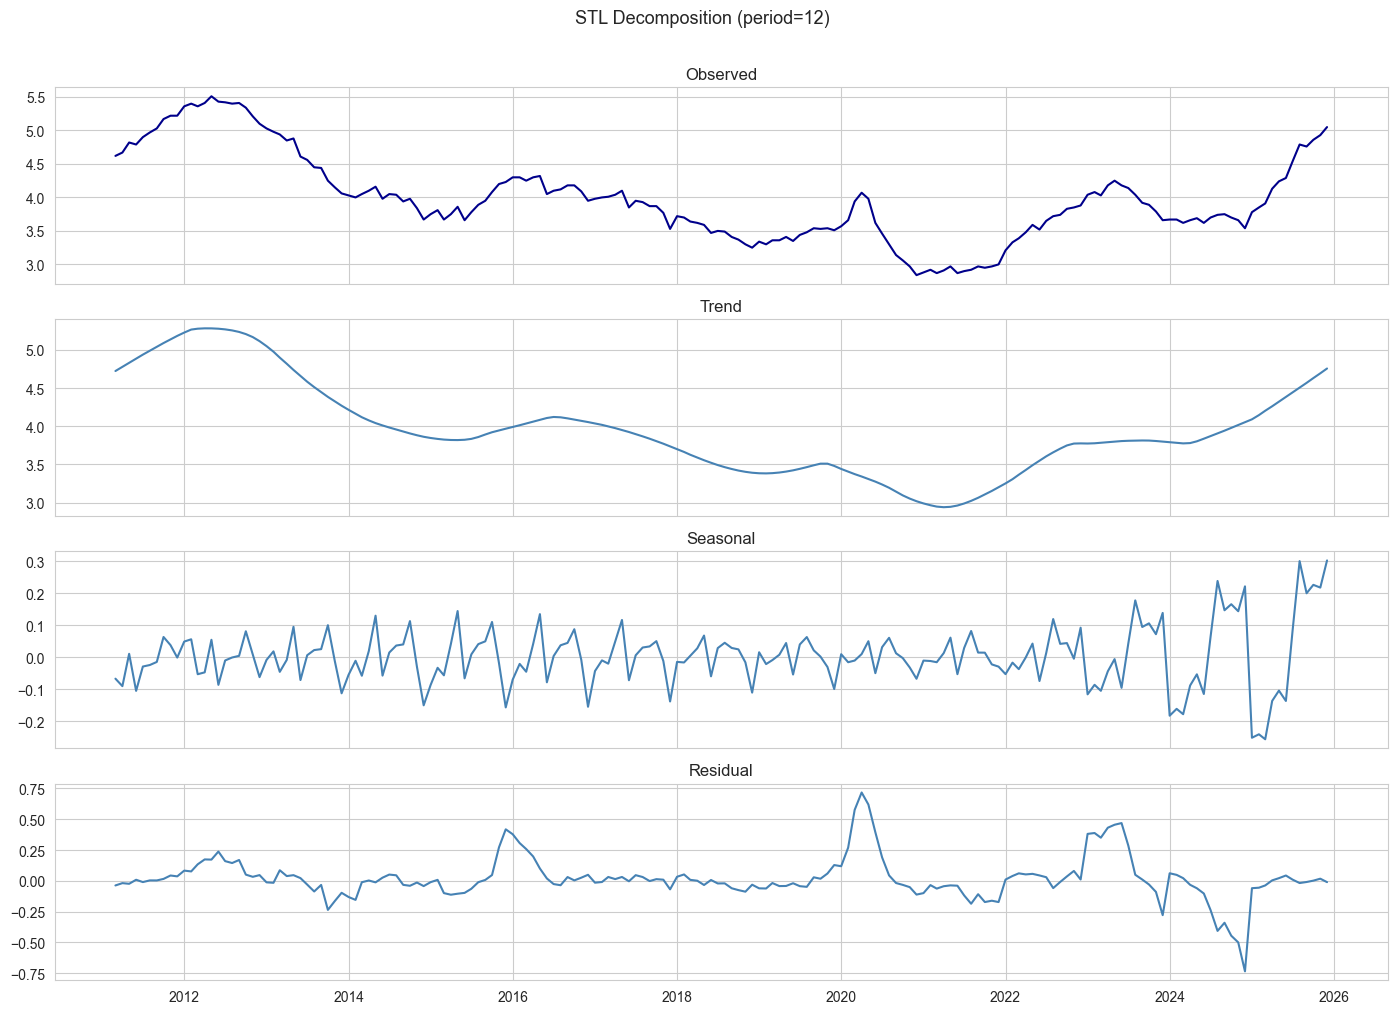

In [14]:
# STL Decomposition
target_clean = target.asfreq("MS").interpolate()
stl = STL(target_clean, period=12, robust=True)
res = stl.fit()

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
for ax, (data, title) in zip(axes, [
    (target_clean, "Observed"), (res.trend, "Trend"),
    (res.seasonal, "Seasonal"), (res.resid, "Residual")
]):
    ax.plot(data, color="darkblue" if title == "Observed" else "steelblue")
    ax.set_title(title)
plt.suptitle("STL Decomposition (period=12)", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

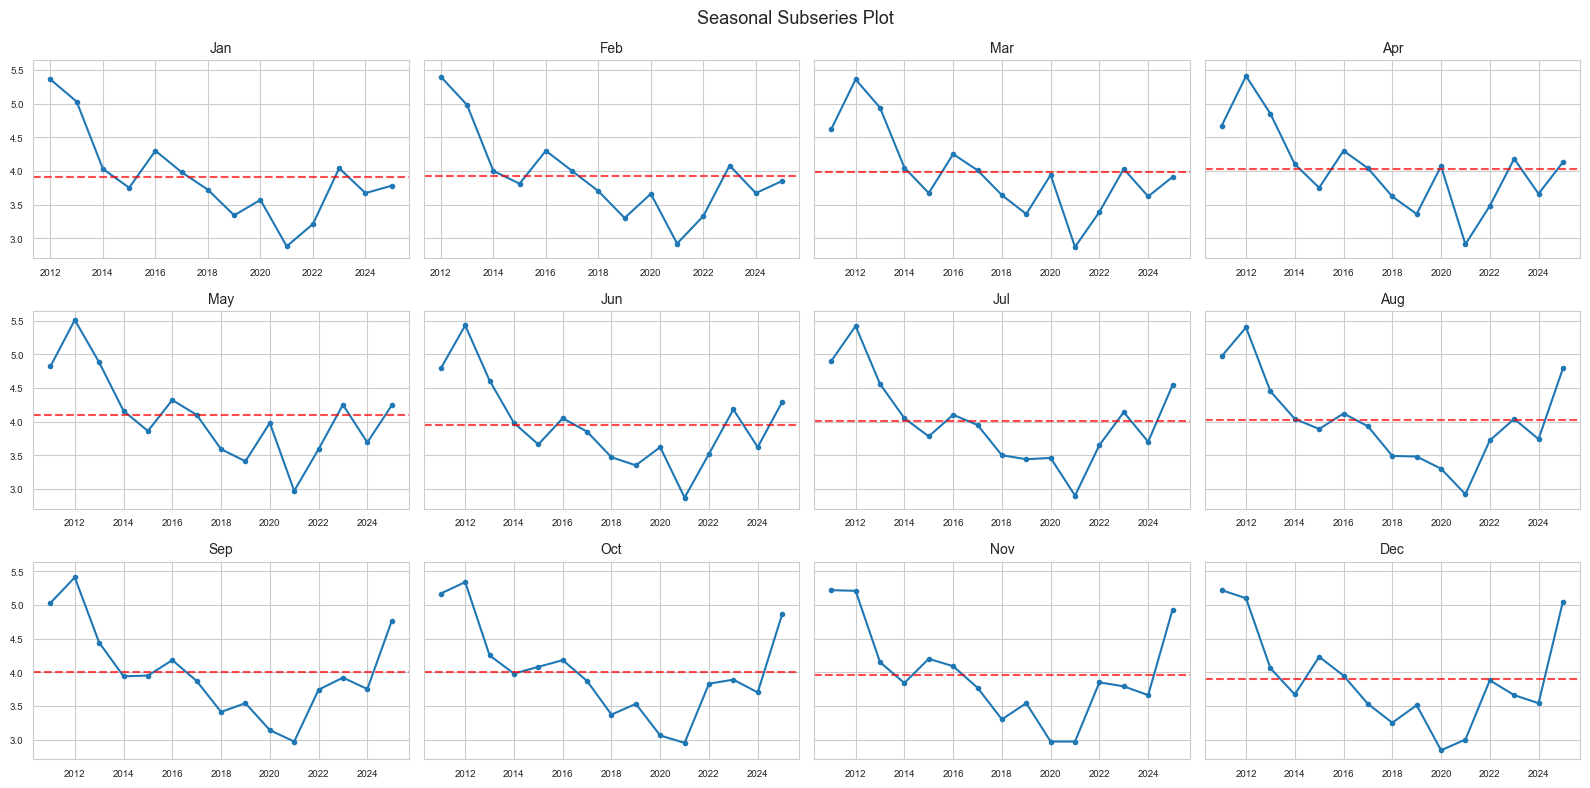

In [15]:
# Seasonal subseries plot
fig, axes = plt.subplots(3, 4, figsize=(16, 8), sharey=True)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
for i, ax in enumerate(axes.flat):
    month_data = target_clean[target_clean.index.month == i + 1]
    ax.plot(month_data.index.year, month_data.values, "o-", markersize=3)
    ax.axhline(month_data.mean(), color="red", linestyle="--", alpha=0.7)
    ax.set_title(months[i], fontsize=10)
    ax.tick_params(labelsize=7)
plt.suptitle("Seasonal Subseries Plot", fontsize=13)
plt.tight_layout()
plt.show()

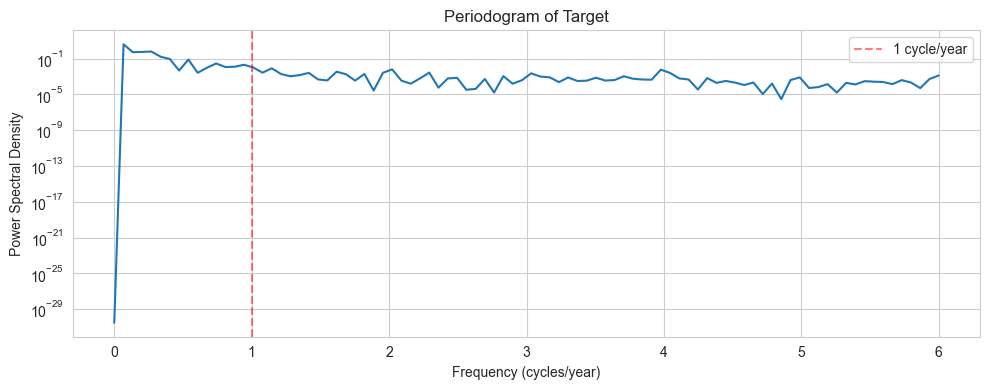

In [16]:
# Periodogram — frequency-domain seasonality check
from scipy.signal import periodogram as pgram

freqs, power = pgram(target_clean.values, fs=12)  # fs=12 for monthly
fig, ax = plt.subplots(figsize=(10, 4))
ax.semilogy(freqs, power)
ax.set_xlabel("Frequency (cycles/year)")
ax.set_ylabel("Power Spectral Density")
ax.set_title("Periodogram of Target")
# Mark annual frequency
ax.axvline(1.0, color="red", linestyle="--", alpha=0.5, label="1 cycle/year")
ax.legend()
plt.tight_layout()
plt.show()

## Section 5: Distribution Analysis

KDE histograms, Q-Q plots, box plots by year, and outlier detection.

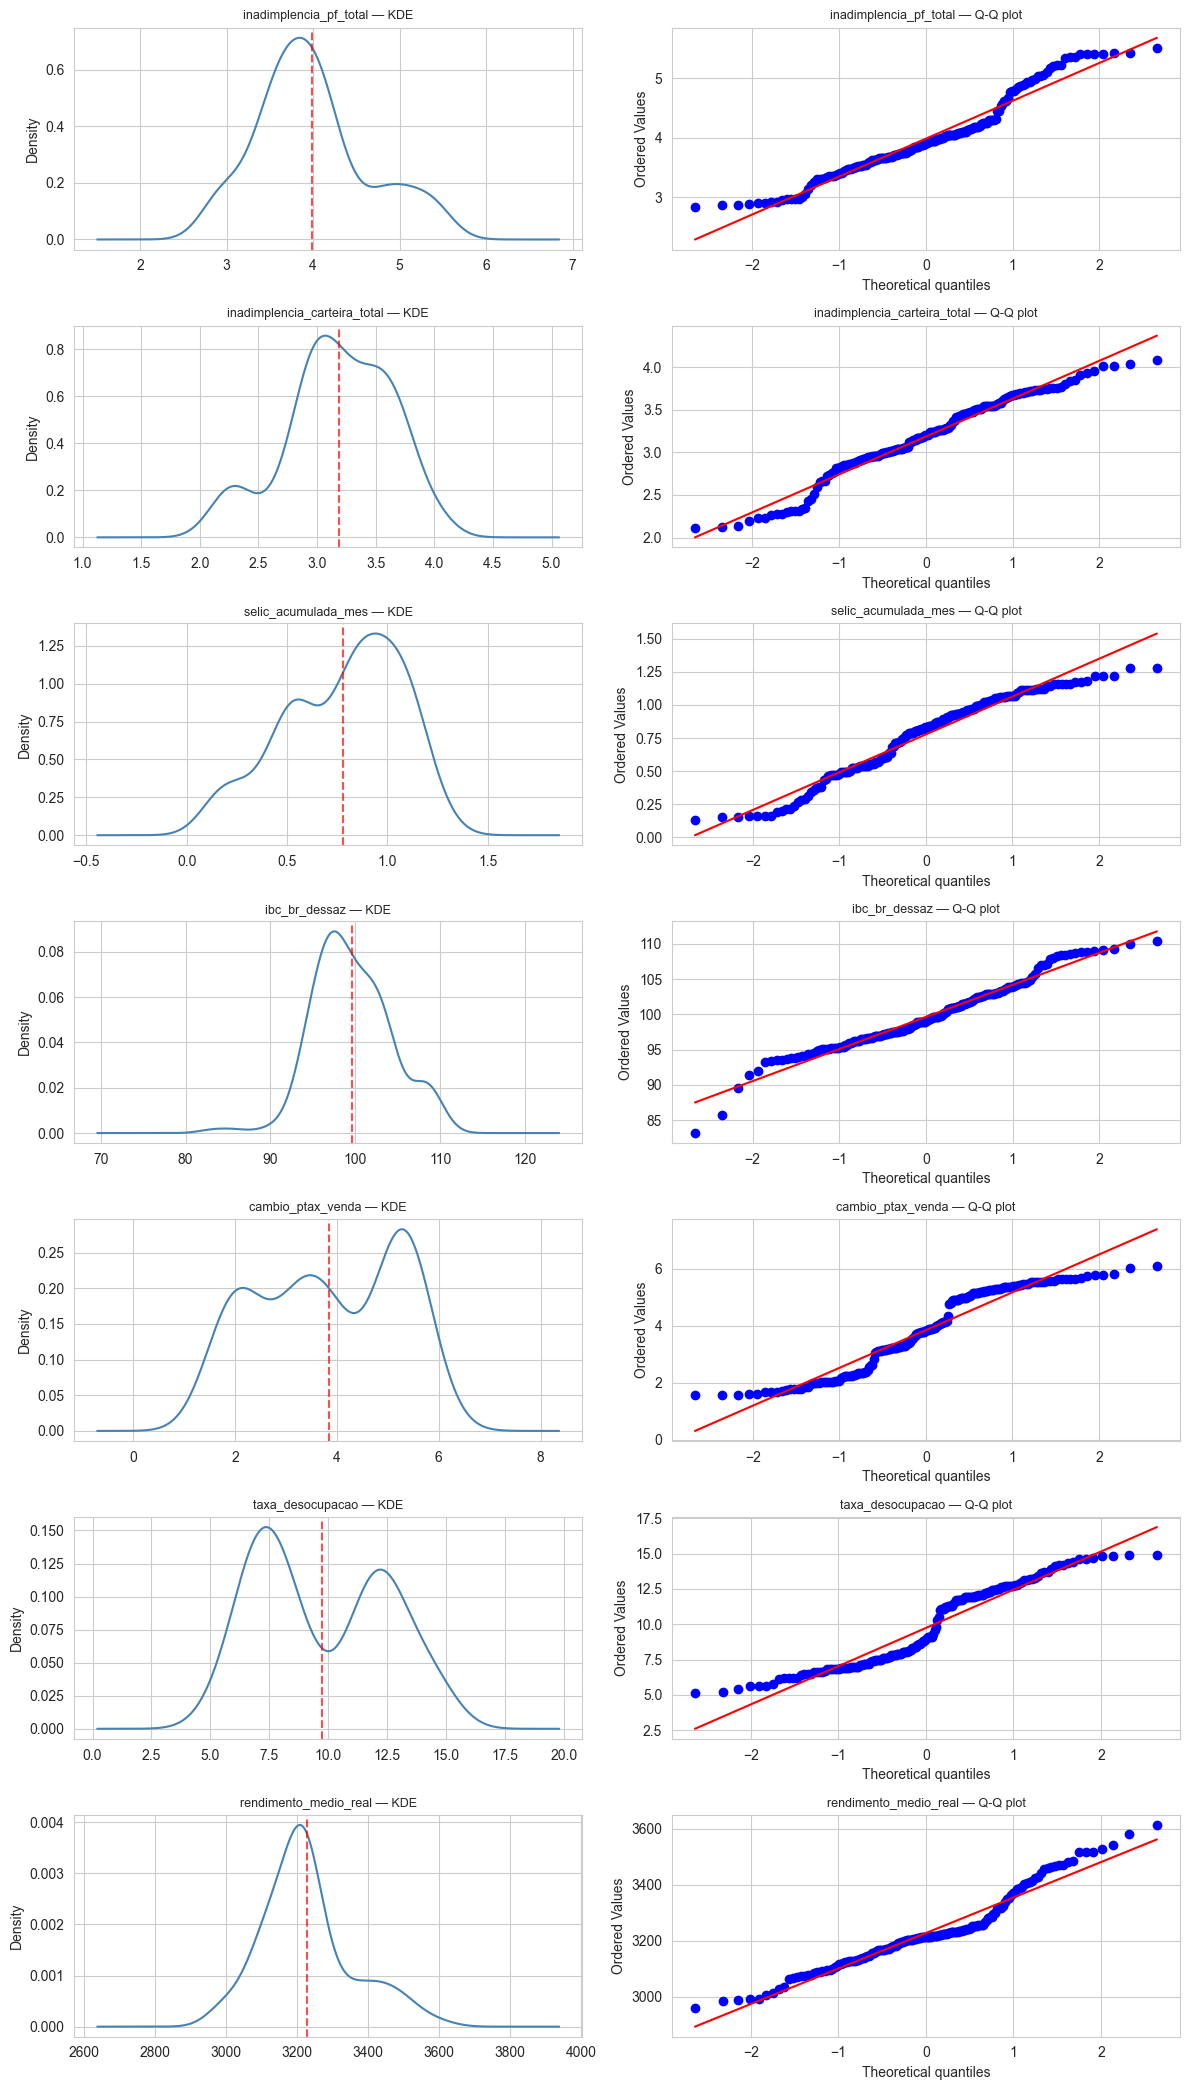

In [17]:
# KDE histograms + Q-Q plots
fig, axes = plt.subplots(len(all_vars), 2, figsize=(12, 3 * len(all_vars)))
for i, col in enumerate(all_vars):
    s = panel[col].dropna()
    # KDE
    s.plot.kde(ax=axes[i, 0], color="steelblue")
    axes[i, 0].axvline(s.mean(), color="red", linestyle="--", alpha=0.7)
    axes[i, 0].set_title(f"{col} — KDE", fontsize=9)
    # Q-Q
    stats.probplot(s.values, dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f"{col} — Q-Q plot", fontsize=9)
plt.tight_layout()
plt.show()

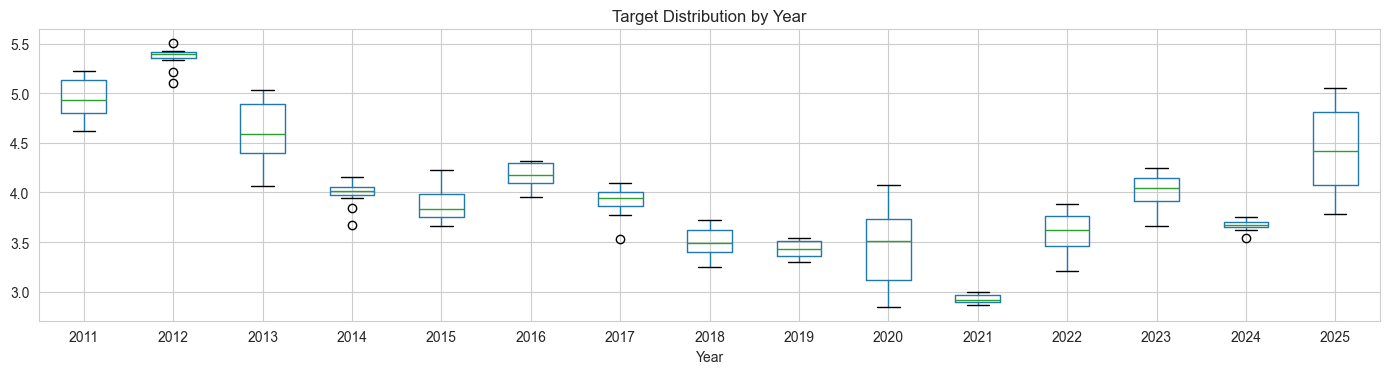

In [18]:
# Box plots by year for target
panel_yr = panel[[TARGET_COL]].copy()
panel_yr["year"] = panel_yr.index.year

fig, ax = plt.subplots(figsize=(14, 4))
panel_yr.dropna().boxplot(column=TARGET_COL, by="year", ax=ax)
ax.set_title("Target Distribution by Year")
ax.set_xlabel("Year")
plt.suptitle("")
plt.tight_layout()
plt.show()

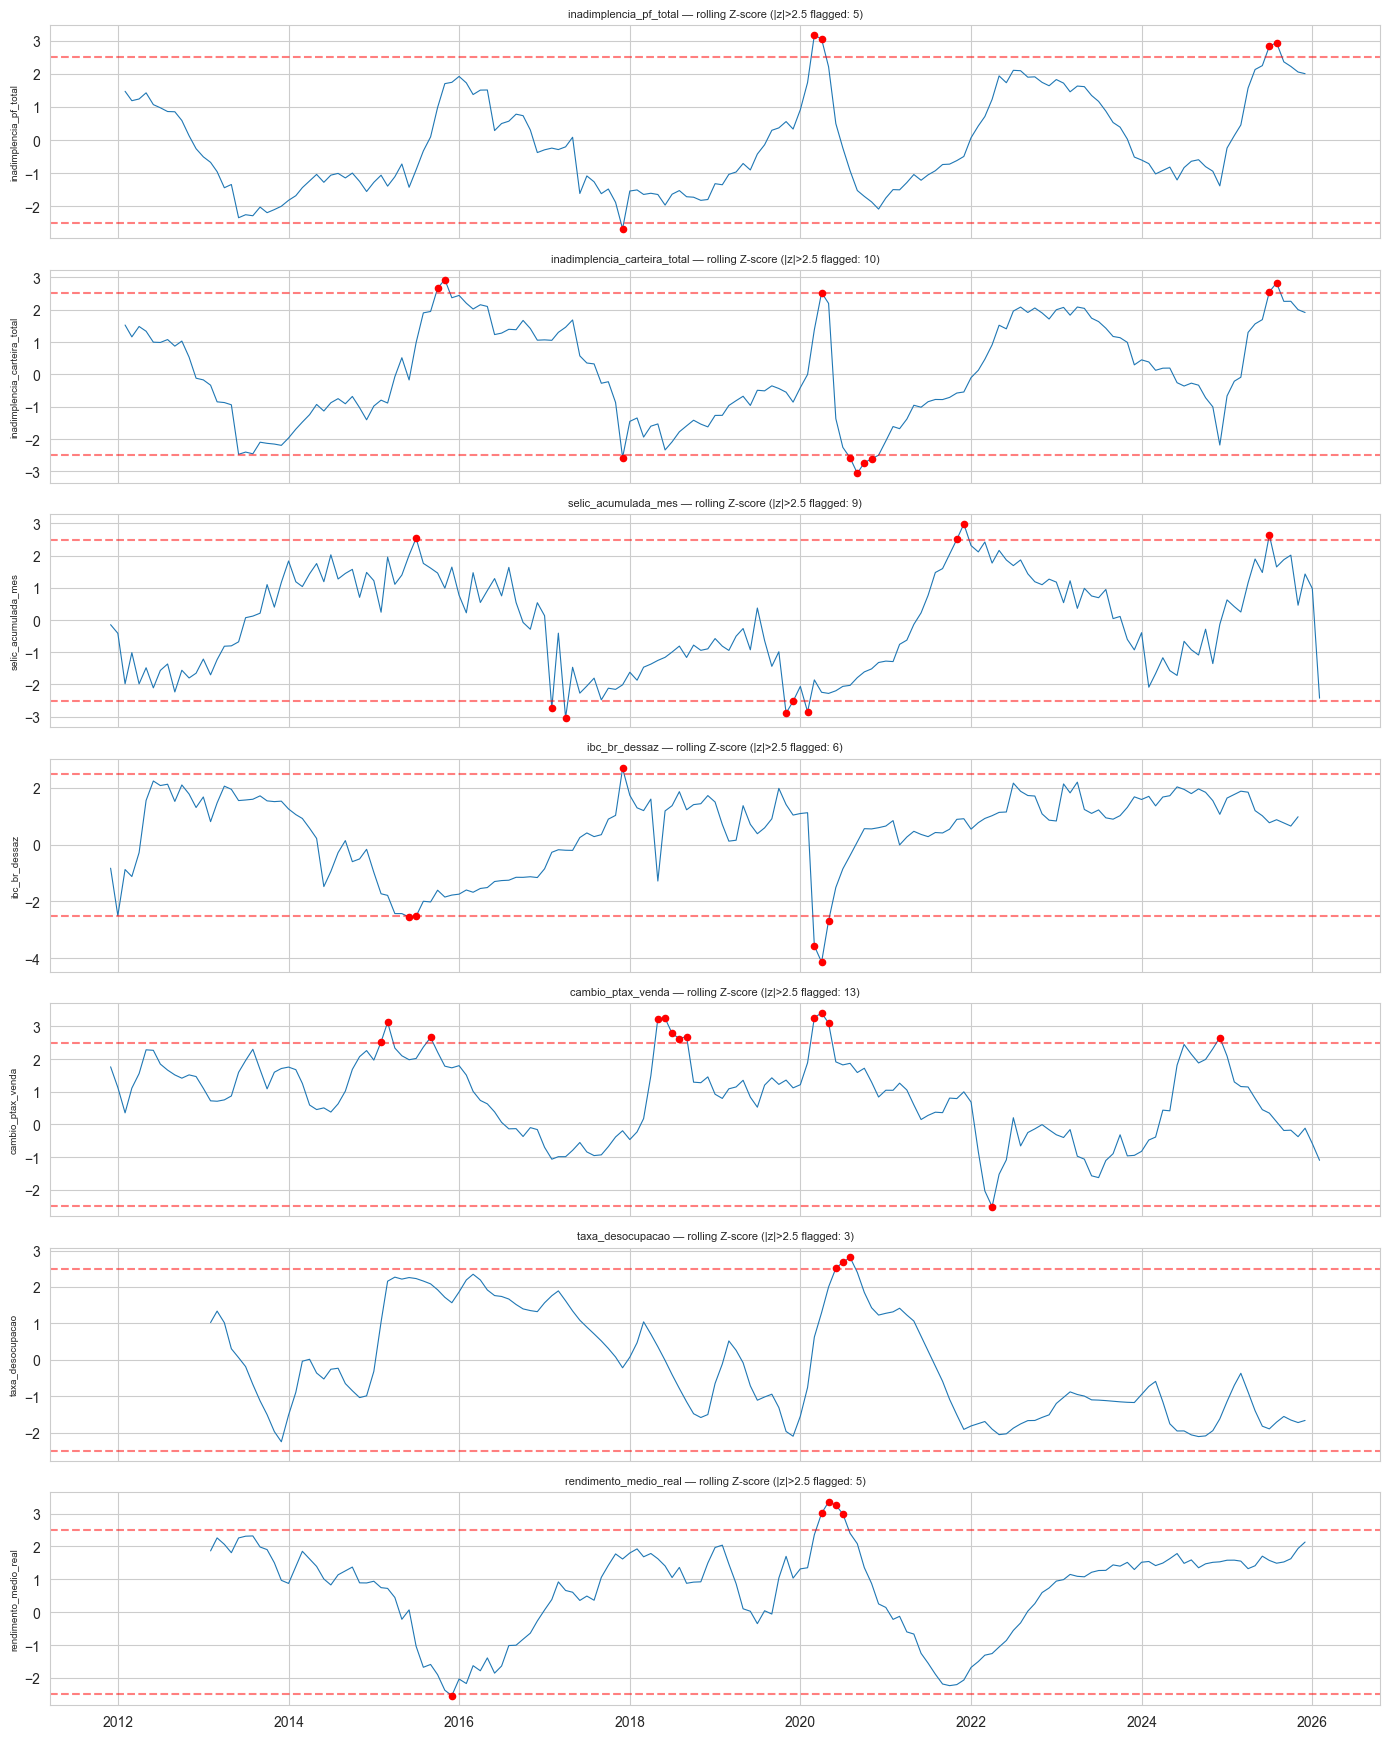

In [19]:
# Rolling Z-score outlier flagging
fig, axes = plt.subplots(len(all_vars), 1, figsize=(14, 2.5 * len(all_vars)), sharex=True)
for ax, col in zip(axes, all_vars):
    s = panel[col].dropna()
    z = (s - s.rolling(24, min_periods=12).mean()) / s.rolling(24, min_periods=12).std()
    ax.plot(z.index, z.values, linewidth=0.8)
    ax.axhline(2.5, color="red", linestyle="--", alpha=0.5)
    ax.axhline(-2.5, color="red", linestyle="--", alpha=0.5)
    outliers = z[z.abs() > 2.5]
    ax.scatter(outliers.index, outliers.values, color="red", s=20, zorder=5)
    ax.set_ylabel(col, fontsize=7)
    ax.set_title(f"{col} — rolling Z-score (|z|>2.5 flagged: {len(outliers)})", fontsize=8)
plt.tight_layout()
plt.show()

## Section 6: Missing Data Patterns

Binary missingness heatmap, effective observations after feature engineering, and forward-fill artifacts.

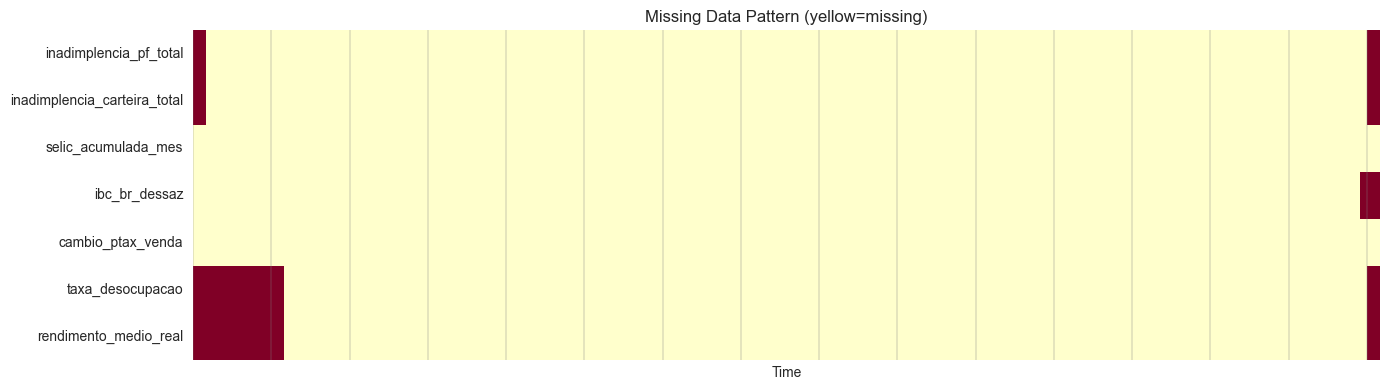

In [20]:
# Binary missingness heatmap
fig, ax = plt.subplots(figsize=(14, 4))
miss = panel.isnull().astype(int)
sns.heatmap(miss.T, cbar=False, cmap="YlOrRd", ax=ax,
            yticklabels=panel.columns, xticklabels=False)
# Add year ticks
years = panel.index.year.unique()
for yr in years:
    idx = panel.index.get_loc(panel.index[panel.index.year == yr][0])
    ax.axvline(idx, color="gray", linewidth=0.3)
ax.set_title("Missing Data Pattern (yellow=missing)")
ax.set_xlabel("Time")
plt.tight_layout()
plt.show()

In [21]:
# Effective observation count after feature engineering
X, y = build_features(panel)
complete_mask = X.notna().all(axis=1) & y.notna()
print(f"Raw panel rows: {len(panel)}")
print(f"Feature matrix rows: {len(X)}")
print(f"Complete cases (no NaN in X or y): {complete_mask.sum()}")
print(f"Rows lost to feature engineering: {len(panel) - complete_mask.sum()}")
print(f"\nPer-column NaN counts in feature matrix:")
print(X.isnull().sum().sort_values(ascending=False).head(15))

2026-02-26 23:08:57 [INFO] src.features: Feature matrix: 182 rows x 33 cols, target: 178 non-null values


Raw panel rows: 182
Feature matrix rows: 182
Complete cases (no NaN in X or y): 160
Rows lost to feature engineering: 22

Per-column NaN counts in feature matrix:
rendimento_medio_real_lag6             20
taxa_desocupacao_lag6                  20
taxa_desocupacao_delta3                19
rendimento_medio_real_delta3           19
rendimento_medio_real_delta1           17
taxa_desocupacao_delta1                17
rendimento_medio_real_lag3             17
taxa_desocupacao_lag3                  17
rendimento_medio_real_lag1             16
taxa_desocupacao_lag1                  16
inadimplencia_carteira_total_lag6       8
inadimplencia_pf_total_ar_lag6          8
inadimplencia_carteira_total_delta3     7
selic_acumulada_mes_lag6                6
ibc_br_dessaz_lag6                      6
dtype: int64


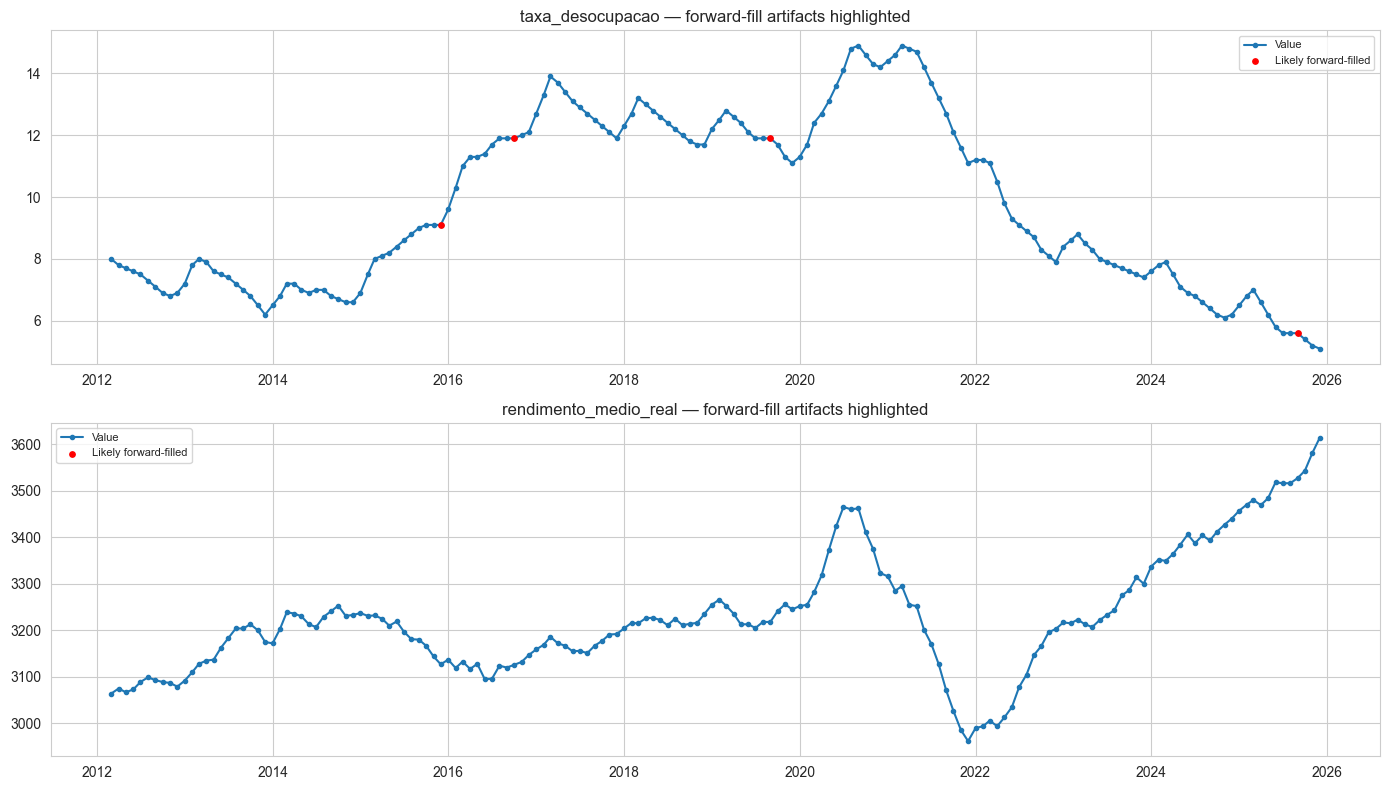

Quarterly PNAD variables are forward-filled to monthly — 2/3 of values are stale.


In [22]:
# Forward-fill artifact visualization for PNAD variables
pnad_cols = ["taxa_desocupacao", "rendimento_medio_real"]
fig, axes = plt.subplots(len(pnad_cols), 1, figsize=(14, 4 * len(pnad_cols)))
for ax, col in zip(axes, pnad_cols):
    s = panel[col]
    ffill_mask = s.notna() & (s == s.shift(1)) & (s == s.shift(2))
    ax.plot(s.index, s.values, "o-", markersize=3, label="Value")
    ax.scatter(s.index[ffill_mask], s.values[ffill_mask],
               color="red", s=15, zorder=5, label="Likely forward-filled")
    ax.set_title(f"{col} — forward-fill artifacts highlighted")
    ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

print("Quarterly PNAD variables are forward-filled to monthly — 2/3 of values are stale.")

## Section 7: Cross-Correlation & Lead-Lag Analysis (Key diagnostic)

CCF plots for each predictor vs target, optimal lead identification.

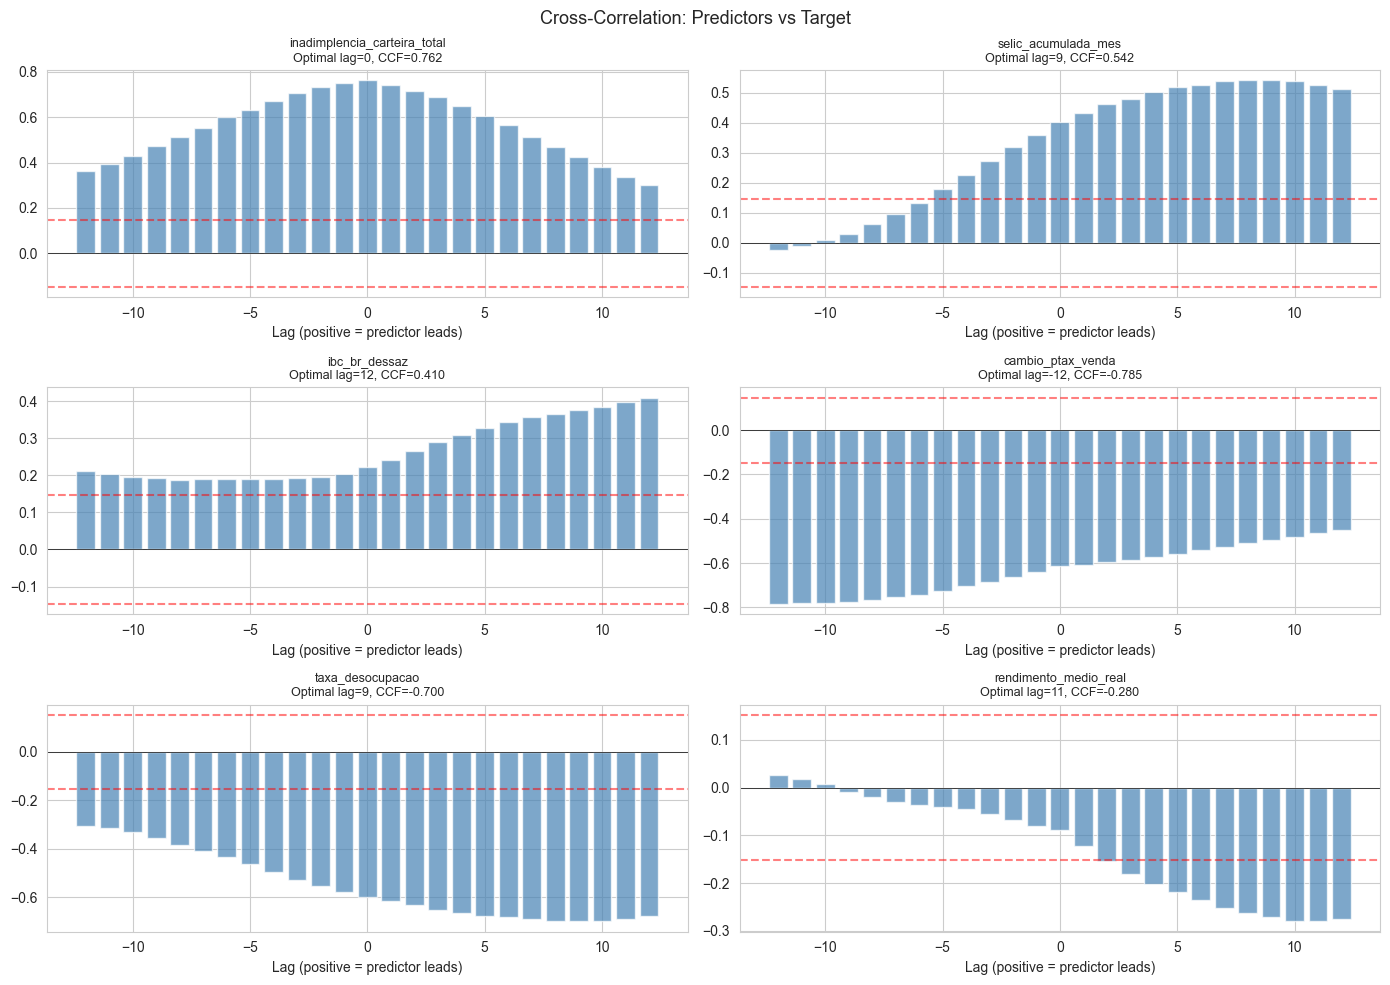

In [23]:
# Cross-correlation function plots
max_lag = 12
ccf_results = {}

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
for ax, col in zip(axes.flat, FEATURE_COLS):
    combined = panel[[TARGET_COL, col]].dropna()
    if len(combined) < 30:
        ax.set_title(f"{col} — insufficient data")
        continue

    t = combined[TARGET_COL].values
    x = combined[col].values
    lags_range = range(-max_lag, max_lag + 1)
    ccf_vals = []
    for lag in lags_range:
        if lag >= 0:
            corr = np.corrcoef(t[lag:], x[:len(x) - lag])[0, 1] if lag < len(x) else np.nan
        else:
            corr = np.corrcoef(t[:len(t) + lag], x[-lag:])[0, 1] if -lag < len(t) else np.nan
        ccf_vals.append(corr)

    ax.bar(list(lags_range), ccf_vals, color="steelblue", alpha=0.7)
    # Significance bounds (approximate)
    n = len(combined)
    ax.axhline(1.96 / np.sqrt(n), color="red", linestyle="--", alpha=0.5)
    ax.axhline(-1.96 / np.sqrt(n), color="red", linestyle="--", alpha=0.5)
    ax.axhline(0, color="black", linewidth=0.5)

    opt_idx = np.nanargmax(np.abs(ccf_vals))
    opt_lag = list(lags_range)[opt_idx]
    opt_ccf = ccf_vals[opt_idx]
    ccf_results[col] = {"optimal_lag": opt_lag, "ccf_optimal": opt_ccf,
                         "ccf_lag1": ccf_vals[max_lag + 1]}

    ax.set_title(f"{col}\nOptimal lag={opt_lag}, CCF={opt_ccf:.3f}", fontsize=9)
    ax.set_xlabel("Lag (positive = predictor leads)")

plt.suptitle("Cross-Correlation: Predictors vs Target", fontsize=13)
plt.tight_layout()
plt.show()

In [24]:
# Lead-lag summary table
ccf_summary = pd.DataFrame(ccf_results).T
ccf_summary["signal_loss"] = 1 - (ccf_summary["ccf_lag1"].abs() / ccf_summary["ccf_optimal"].abs())
ccf_summary = ccf_summary.sort_values("ccf_optimal", key=abs, ascending=False)
print("Lead-Lag Summary — signal loss = how much CCF drops from optimal to lag=1")
ccf_summary.round(3)

Lead-Lag Summary — signal loss = how much CCF drops from optimal to lag=1


,optimal_lag,ccf_optimal,ccf_lag1,signal_loss
cambio_ptax_venda,-12.0,-0.785,-0.607,0.227
inadimplencia_carteira_total,0.0,0.762,0.740,0.028
taxa_desocupacao,9.0,-0.700,-0.614,0.122
selic_acumulada_mes,9.0,0.542,0.433,0.201
ibc_br_dessaz,12.0,0.410,0.241,0.412
rendimento_medio_real,11.0,-0.280,-0.123,0.562


## Section 8: Rolling Correlations

36-month rolling correlations and sign stability analysis.

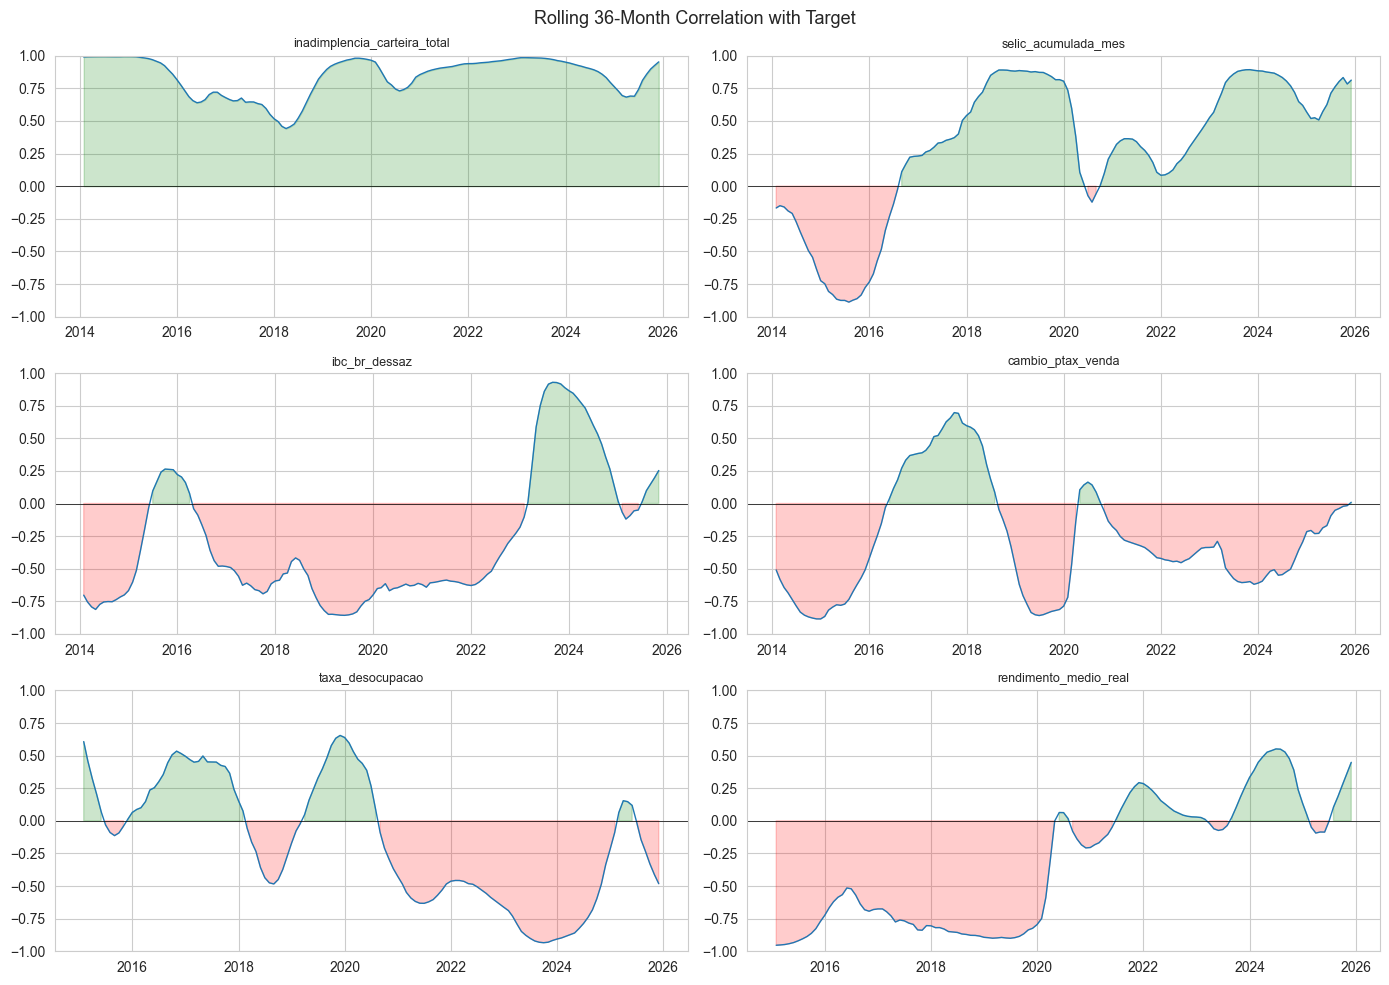

In [25]:
# 36-month rolling correlations
window = 36
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
sign_stability = {}

for ax, col in zip(axes.flat, FEATURE_COLS):
    combined = panel[[TARGET_COL, col]].dropna()
    rolling_corr = combined[TARGET_COL].rolling(window).corr(combined[col])
    ax.plot(rolling_corr.index, rolling_corr.values, linewidth=1)
    ax.axhline(0, color="black", linewidth=0.5)
    ax.fill_between(rolling_corr.index, rolling_corr.values, 0,
                     where=rolling_corr > 0, alpha=0.2, color="green")
    ax.fill_between(rolling_corr.index, rolling_corr.values, 0,
                     where=rolling_corr < 0, alpha=0.2, color="red")
    ax.set_title(f"{col}", fontsize=9)
    ax.set_ylim(-1, 1)

    rc = rolling_corr.dropna()
    pct_pos = (rc > 0).mean() * 100
    pct_strong = (rc.abs() > 0.3).mean() * 100
    sign_stability[col] = {"pct_positive": pct_pos, "pct_strong": pct_strong}

plt.suptitle(f"Rolling {window}-Month Correlation with Target", fontsize=13)
plt.tight_layout()
plt.show()

In [26]:
# Sign stability table
stability_df = pd.DataFrame(sign_stability).T.round(1)
stability_df.columns = ["% time positive", "% time |r|>0.3"]
print("Sign Stability of Rolling Correlations")
stability_df

Sign Stability of Rolling Correlations


,% time positive,% time |r|>0.3
inadimplencia_carteira_total,100.0,100.0
selic_acumulada_mes,76.2,72.7
ibc_br_dessaz,26.8,75.4
cambio_ptax_venda,23.8,71.3
taxa_desocupacao,40.5,67.9
rendimento_medio_real,35.9,57.3


## Section 9: Granger Causality Tests

Direct test: does each predictor improve on an AR model of the target?

In [28]:
# Granger causality tests (on stationary series — use first differences for I(1) vars)
granger_rows = []

for col in FEATURE_COLS:
    combined = panel[[TARGET_COL, col]].dropna()
    if len(combined) < 30:
        continue

    # Use first differences for stationarity
    diff_data = combined.diff().dropna()
    if diff_data.isnull().any().any() or len(diff_data) < 20:
        continue

    try:
        gc = grangercausalitytests(diff_data[[TARGET_COL, col]], maxlag=6, verbose=False)
        min_p = min(gc[lag][0]["ssr_ftest"][1] for lag in range(1, 7))
        best_lag = min(range(1, 7), key=lambda l: gc[l][0]["ssr_ftest"][1])
        granger_rows.append({
            "predictor": col,
            "min_p_value": round(min_p, 4),
            "best_lag": best_lag,
            "significant_5pct": min_p < 0.05,
        })
    except Exception as e:
        granger_rows.append({"predictor": col, "min_p_value": np.nan,
                             "best_lag": np.nan, "significant_5pct": False})

granger_df = pd.DataFrame(granger_rows).sort_values("min_p_value")
print("Granger Causality Test Summary (H0: predictor does NOT Granger-cause target)")
print("On first-differenced series, maxlag=6\n")
granger_df

Granger Causality Test Summary (H0: predictor does NOT Granger-cause target)
On first-differenced series, maxlag=6



,predictor,min_p_value,best_lag,significant_5pct
4,taxa_desocupacao,0.0002,3,True
0,inadimplencia_carteira_total,0.0019,2,True
1,selic_acumulada_mes,0.0021,2,True
2,ibc_br_dessaz,0.0038,3,True
5,rendimento_medio_real,0.0549,3,False
3,cambio_ptax_venda,0.3434,3,False


## Section 10: Cointegration Analysis

Engle-Granger test for I(1) predictor-target pairs.

In [29]:
# Cointegration tests (Engle-Granger) for I(1) variable pairs
i1_vars = stationarity_df[stationarity_df["I(d)"] >= 1]["variable"].tolist()
coint_rows = []

target_s = panel[TARGET_COL].dropna()

for col in i1_vars:
    if col == TARGET_COL:
        continue
    combined = panel[[TARGET_COL, col]].dropna()
    if len(combined) < 30:
        continue
    try:
        t_stat, p_val, crit = coint(combined[TARGET_COL], combined[col])
        coint_rows.append({
            "predictor": col,
            "t_stat": round(t_stat, 3),
            "p_value": round(p_val, 4),
            "cointegrated_5pct": p_val < 0.05,
        })
    except Exception:
        pass

coint_df = pd.DataFrame(coint_rows).sort_values("p_value")
print("Engle-Granger Cointegration Test (H0: no cointegration)")
coint_df

Engle-Granger Cointegration Test (H0: no cointegration)


,predictor,t_stat,p_value,cointegrated_5pct
4,taxa_desocupacao,-3.646,0.0215,True
1,selic_acumulada_mes,-3.084,0.0915,False
2,ibc_br_dessaz,-2.740,0.1857,False
0,inadimplencia_carteira_total,-2.355,0.3465,False
5,rendimento_medio_real,-1.662,0.6939,False
3,cambio_ptax_venda,-1.421,0.7903,False


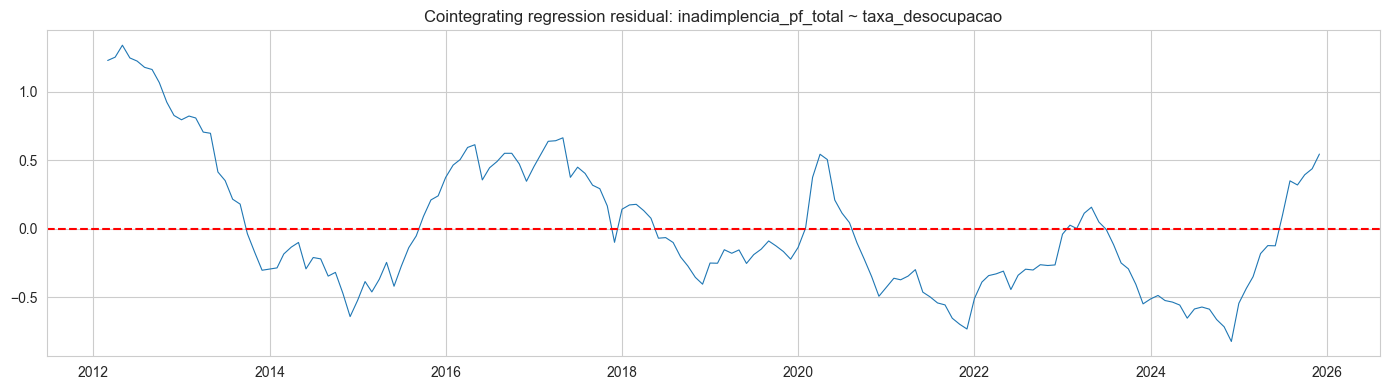

In [30]:
# Residual plots for cointegrating regressions
coint_pairs = coint_df[coint_df["cointegrated_5pct"]]["predictor"].tolist()
if coint_pairs:
    fig, axes = plt.subplots(len(coint_pairs), 1, figsize=(14, 4 * len(coint_pairs)))
    if len(coint_pairs) == 1:
        axes = [axes]
    for ax, col in zip(axes, coint_pairs):
        combined = panel[[TARGET_COL, col]].dropna()
        # OLS regression
        from numpy.polynomial.polynomial import polyfit
        b, a = np.polyfit(combined[col], combined[TARGET_COL], 1)
        resid = combined[TARGET_COL] - (b * combined[col] + a)
        ax.plot(resid.index, resid.values, linewidth=0.8)
        ax.axhline(0, color="red", linestyle="--")
        ax.set_title(f"Cointegrating regression residual: {TARGET_COL} ~ {col}")
    plt.tight_layout()
    plt.show()
else:
    print("No cointegrated pairs found at 5% significance level.")

## Section 11: Multicollinearity Diagnostics

Feature matrix correlation, VIF, and condition number.

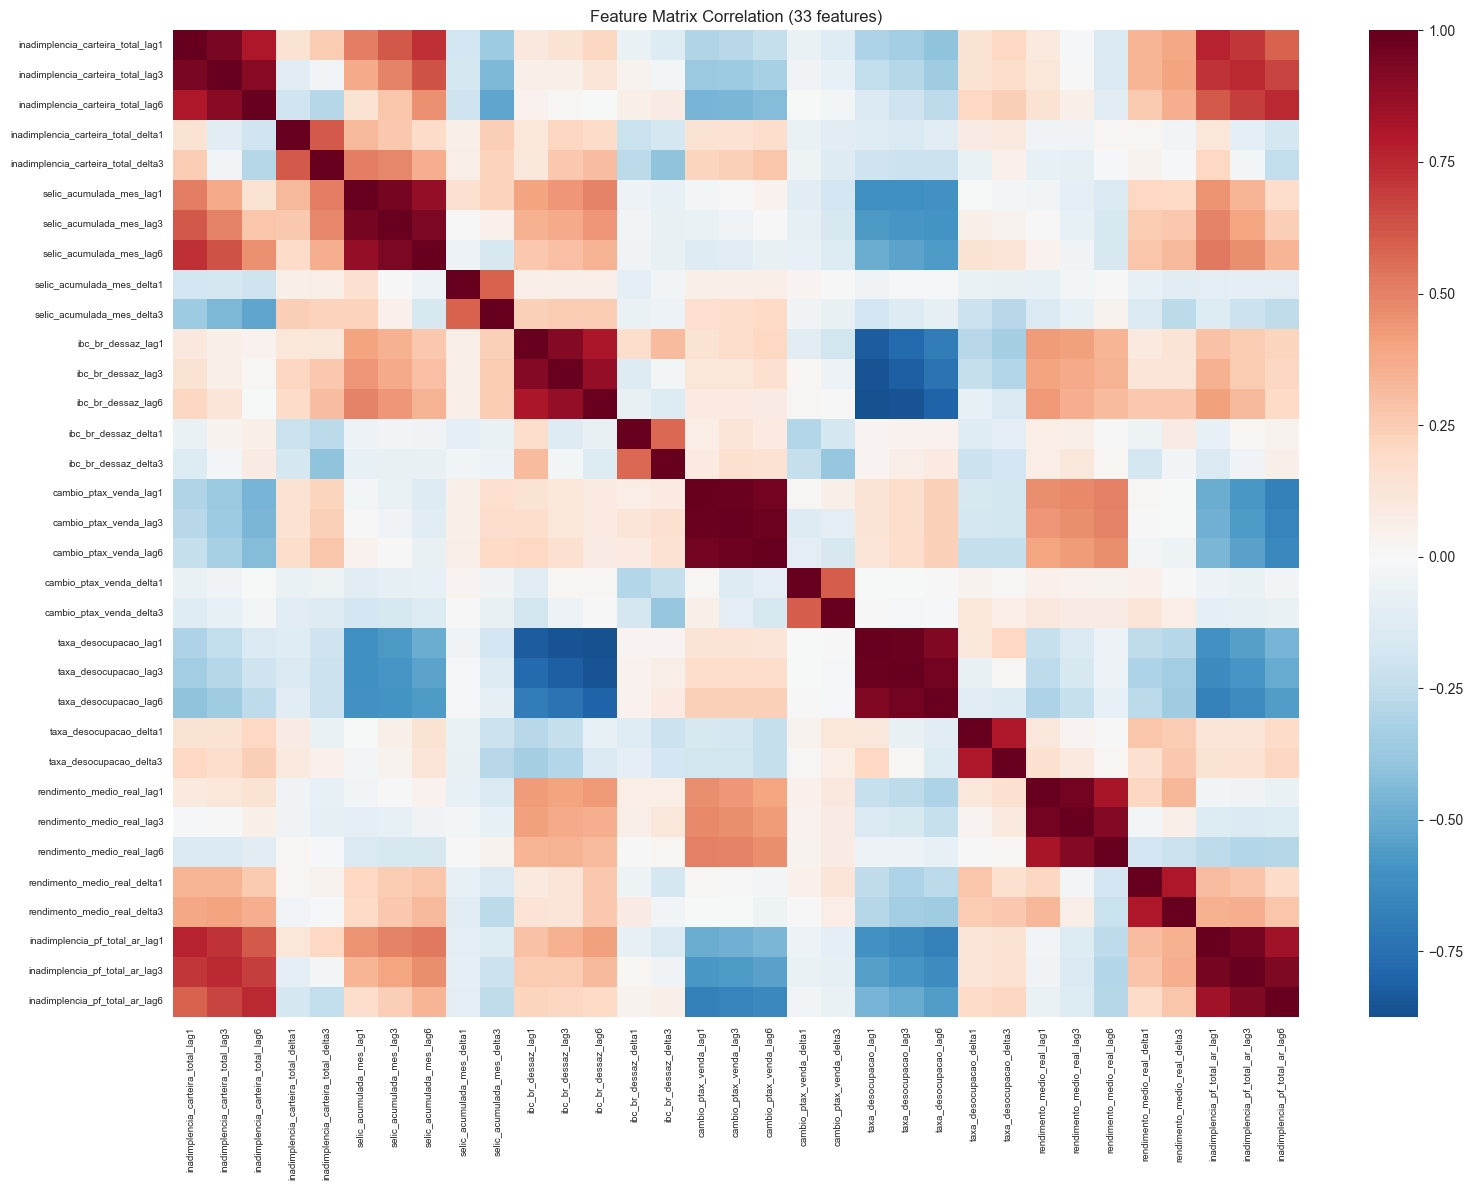

In [31]:
# Feature matrix correlation heatmap
X_complete = X.dropna()
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(X_complete.corr(), cmap="RdBu_r", center=0, ax=ax,
            xticklabels=True, yticklabels=True)
ax.set_title(f"Feature Matrix Correlation ({X_complete.shape[1]} features)")
ax.tick_params(labelsize=7)
plt.tight_layout()
plt.show()

In [32]:
# VIF for each feature
from sklearn.preprocessing import StandardScaler

X_scaled = pd.DataFrame(
    StandardScaler().fit_transform(X_complete),
    columns=X_complete.columns, index=X_complete.index
)

vif_data = []
for i, col in enumerate(X_scaled.columns):
    vif_val = variance_inflation_factor(X_scaled.values, i)
    vif_data.append({"feature": col, "VIF": round(vif_val, 1)})

vif_df = pd.DataFrame(vif_data).sort_values("VIF", ascending=False)
vif_df["flag"] = vif_df["VIF"].apply(lambda v: "HIGH" if v > 10 else "")

print(f"Condition number of feature matrix: {np.linalg.cond(X_scaled.values):.0f}")
print(f"\nFeatures with VIF > 10: {(vif_df['VIF'] > 10).sum()} / {len(vif_df)}\n")
vif_df

Condition number of feature matrix: 168

Features with VIF > 10: 24 / 33



,feature,VIF,flag
20,taxa_desocupacao_lag1,1701.9,HIGH
21,taxa_desocupacao_lag3,1310.1,HIGH
15,cambio_ptax_venda_lag1,265.2,HIGH
25,rendimento_medio_real_lag1,232.9,HIGH
16,cambio_ptax_venda_lag3,212.6,HIGH
31,inadimplencia_pf_total_ar_lag3,182.2,HIGH
26,rendimento_medio_real_lag3,166.4,HIGH
1,inadimplencia_carteira_total_lag3,129.7,HIGH
0,inadimplencia_carteira_total_lag1,107.3,HIGH
30,inadimplencia_pf_total_ar_lag1,93.0,HIGH


## Section 12: Feature-Target Relationships

Bivariate R², partial regression after AR(1), incremental value of macro variables.

In [33]:
# Bivariate R² and incremental R² over AR(1)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Prepare complete data
ar1_col = f"{TARGET_COL}_ar_lag1"
Xy = X.join(y).dropna()
y_vals = Xy[TARGET_COL]
X_vals = Xy.drop(columns=[TARGET_COL])

# AR(1) baseline R²
ar1 = LinearRegression().fit(X_vals[[ar1_col]], y_vals)
r2_ar1 = r2_score(y_vals, ar1.predict(X_vals[[ar1_col]]))

r2_rows = []
for col in X_vals.columns:
    # Bivariate R²
    lr = LinearRegression().fit(X_vals[[col]], y_vals)
    r2_biv = r2_score(y_vals, lr.predict(X_vals[[col]]))

    # R² with AR(1) + this feature
    lr2 = LinearRegression().fit(X_vals[[ar1_col, col]], y_vals)
    r2_with = r2_score(y_vals, lr2.predict(X_vals[[ar1_col, col]]))

    r2_rows.append({
        "feature": col,
        "bivariate_R2": round(r2_biv, 4),
        "AR1_plus_feature_R2": round(r2_with, 4),
        "incremental_R2": round(r2_with - r2_ar1, 4),
    })

r2_df = pd.DataFrame(r2_rows).sort_values("incremental_R2", ascending=False)
print(f"AR(1) baseline R²: {r2_ar1:.4f}\n")
r2_df.head(15)

AR(1) baseline R²: 0.9618



,feature,bivariate_R2,AR1_plus_feature_R2,incremental_R2
5,selic_acumulada_mes_lag1,0.2485,0.9667,0.0049
11,ibc_br_dessaz_lag3,0.1648,0.9658,0.0040
32,inadimplencia_pf_total_ar_lag6,0.6313,0.9653,0.0035
4,inadimplencia_carteira_total_delta3,0.0652,0.9649,0.0031
10,ibc_br_dessaz_lag1,0.1179,0.9649,0.0031
12,ibc_br_dessaz_lag6,0.2065,0.9648,0.0030
6,selic_acumulada_mes_lag3,0.2788,0.9647,0.0029
31,inadimplencia_pf_total_ar_lag3,0.8480,0.9646,0.0028
21,taxa_desocupacao_lag3,0.4425,0.9645,0.0027
20,taxa_desocupacao_lag1,0.3968,0.9643,0.0026


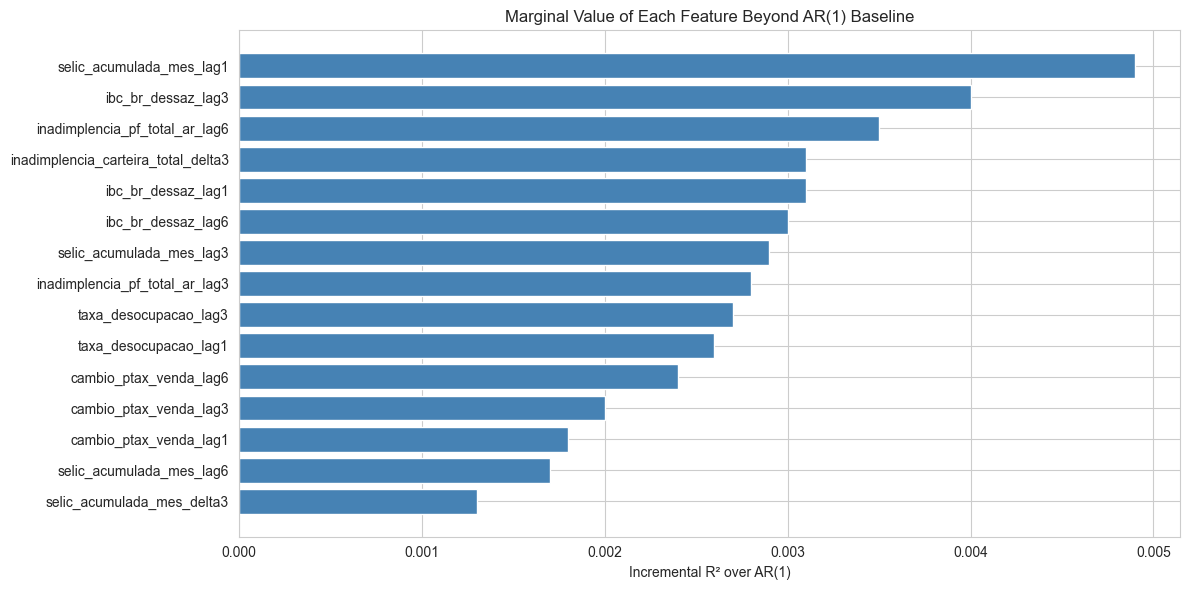

In [34]:
# Incremental R² bar chart — top 15 features
top15 = r2_df.head(15)
colors = ["steelblue" if v > 0 else "salmon" for v in top15["incremental_R2"]]

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(top15["feature"], top15["incremental_R2"], color=colors)
ax.axvline(0, color="black", linewidth=0.5)
ax.set_xlabel("Incremental R² over AR(1)")
ax.set_title("Marginal Value of Each Feature Beyond AR(1) Baseline")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Section 13: Diagnostic Summary

### Why does ARIMA beat macro-augmented models?

| Hypothesis | Test | Finding |
|---|---|---|
| **Target is highly persistent** | ACF/PACF (Sec 1) | ACF decays very slowly — AR lags are extremely informative |
| **Macro vars fail Granger test** | Granger causality (Sec 9) | Check table above — if most p > 0.05, macro vars add no causal signal |
| **Correlations are unstable** | Rolling correlations (Sec 8) | Sign changes across regimes erode full-sample relationships |
| **PNAD noise from forward-fill** | Missing patterns (Sec 6) | Quarterly→monthly fill creates stale values, adding noise |
| **Severe multicollinearity** | VIF (Sec 11) | Multiple features with VIF > 10 → unstable coefficient estimates |
| **Suboptimal lag structure** | CCF analysis (Sec 7) | Signal loss ratio shows lag=1 may not be optimal for all predictors |
| **Spurious level regressions** | Stationarity (Sec 2) | I(1) variables used in levels → potential spurious regression |
| **No cointegration** | Engle-Granger (Sec 10) | If pairs not cointegrated, level relationships are unreliable |

### Recommended Next Steps

1. **Difference-based features**: Replace level lags with first-difference lags for I(1) variables
2. **Optimal lag selection**: Use CCF-derived optimal lags instead of fixed {1,3,6}
3. **Feature selection**: Drop features with VIF > 10 and no Granger significance
4. **Regime-aware modeling**: Consider regime-switching or time-varying parameter models
5. **PNAD handling**: Use quarterly frequency directly or interpolation methods instead of forward-fill
6. **Error correction terms**: For cointegrated pairs, add ECM residuals as features